# Spatial ATAC-RNA Seq Mouse Brain

- **Creator**: Sebastian Birk (<sebastian.birk@helmholtz-munich.de>)
- **Date of Creation:** 22.01.2023
- **Date of Last Modification:** 22.12.2024

- In order to run this notebook, a trained model needs to be stored under ```../artifacts/{dataset}/models/{model_label}/{load_timestamp}```.
- Load timestamp: ```13092023_174230```

## 1. Setup

### 1.1 Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../../utils")

In [3]:
import argparse
import gc
import os
import random
import shutil
import warnings
from datetime import datetime

import anndata as ad
import matplotlib
import matplotlib.pyplot as plt
import mlflow
import networkx as nx
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.sparse as sp
import scipy.stats as stats
import seaborn as sns
import squidpy as sq
import torch
from matplotlib import gridspec
from matplotlib.pyplot import rc_context
from pywaffle import Waffle
from sklearn.preprocessing import MinMaxScaler

from nichecompass.models import NicheCompass
from nichecompass.utils import (add_gps_from_gp_dict_to_adata,
                                aggregate_obsp_matrix_per_cell_type,
                                create_cell_type_chord_plot_from_df,
                                create_new_color_dict,
                                compute_communication_gp_network,
                                generate_enriched_gp_info_plots,
                                visualize_communication_gp_network)

from analysis_utils import (add_cell_type_latent_cluster_emphasis,
                            add_sub_cell_type,
                            compute_cell_type_latent_clusters,
                            generate_gp_info_plots,
                            plot_category_in_latent_and_physical_space,
                            plot_cell_type_latent_clusters,
                            plot_latent,
                            plot_physical_latent_for_cell_types,
                            sankey,
                            store_top_gps_summary)

  File "/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/urllib3/connectionpool.py", line 404, in _make_request
    self._validate_conn(conn)
  File "/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/urllib3/connectionpool.py", line 1060, in _validate_conn
    conn.connect()
  File "/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/urllib3/connection.py", line 419, in connect
    self.sock = ssl_wrap_socket(
  File "/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/urllib3/util/ssl_.py", line 449, in ssl_wrap_socket
    ssl_sock = _ssl_wrap_socket_impl(
  File "/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/urllib3/util/ssl_.py", line 493, in _ssl_wrap_socket_impl
    return ssl_context.wrap_socket(sock, server_hostname=server_hostname)
  File "/

### 1.2 Define Parameters

In [4]:
dataset = "spatial_atac_rna_seq_mouse_brain_batch2"

#### 1.2.1 Generic Parameters

In [5]:
## Model
# AnnData keys
adj_key = "spatial_connectivities"
spatial_key = "spatial"
sub_cell_type_key = "sub_cell_type"
gp_names_key = "nichecompass_gp_names"
active_gp_names_key = "nichecompass_active_gp_names"
latent_key = "nichecompass_latent"
mapping_entity_key = "mapping_entity"

## Analysis
differential_gp_test_results_key = "nichecompass_differential_gp_test_results"

## Others
random_seed = 0

#### 1.2.2 Dataset-specific Parameters

In [6]:
cell_type_groups = []
latent_groups = []

load_timestamp = "13092023_174230"
model_label = "reference"
cell_type_key = "celltype"
rna_cluster_key = "RNA_clusters"
atac_cluster_key = "ATAC_clusters"
dataset_str = "Spatial ATAC-RNA-Seq Mouse Brain"
sample_key = "batch"
samples = ["p22"]
condition_key = "batch"
latent_leiden_resolution = 0.3
latent_cluster_spot_size = 30
latent_groups = []
multimodal = True
spot_size = 30
cell_type_groups = []
feature_spaces = ["p22"]
log_norm_omics_features = True
    
latent_cluster_key = f"latent_leiden_{str(latent_leiden_resolution)}"

### 1.3 Run Notebook Setup

In [7]:
sc.set_figure_params(figsize=(6, 6))
# sc.set_figure_params(dpi=300)
sns.set_style("whitegrid", {'axes.grid' : False})

In [8]:
# Ignore future warnings and user warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)

In [9]:
plt.rcParams['font.family'] = 'Helvetica'
plt.rcParams['font.size'] = 5

### 1.4 Configure Paths and Create Directories

In [10]:
# Define paths
figure_folder_path = f"../../artifacts/{dataset}/figures/{model_label}/{load_timestamp}"
model_folder_path = f"../../artifacts/{dataset}/models/{model_label}/{load_timestamp}"
result_folder_path = f"../../artifacts/{dataset}/results/{model_label}/{load_timestamp}"
gp_data_folder_path = "../../datasets/gp_data" # gene program data
ga_data_folder_path = "../../datasets/ga_data"
srt_data_folder_path = "../../datasets/st_data" # spatially resolved transcriptomics data
srt_data_gold_folder_path = f"{srt_data_folder_path}/gold"

# Create required directories
os.makedirs(figure_folder_path, exist_ok=True)
os.makedirs(result_folder_path, exist_ok=True)

## 2. Model

### 2.1 Load Model

In [11]:
model = NicheCompass.load(dir_path=model_folder_path,
                          adata=None,
                          adata_file_name=f"{dataset}_{model_label}.h5ad",
                          adata_atac=None,
                          adata_atac_file_name=f"{dataset}_{model_label}_atac.h5ad",
                          gp_names_key=gp_names_key)

--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, rna_recon_loss: nb, include_chrom_access_recon_loss: True, atac_recon_loss: nb 
NODE LABEL METHOD -> one-hop-norm
ACTIVE GP THRESHOLD RATIO -> 0.01
LOG VARIATIONAL -> True
ONE HOP GCN NORM RNA NODE LABEL AGGREGATOR
ONE HOP GCN NORM ATAC NODE LABEL AGGREGATOR
ENCODER -> n_input: 6122, n_cat_covariates_embed_input: 0, n_hidden: 1034, n_latent: 934, n_addon_latent: 100, n_fc_layers: 1, n_layers: 1, conv_layer: gatv2conv, n_attention_heads: 4, dropout_rate: 0.0, 
COSINE SIM GRAPH DECODER -> dropout_rate: 0.0
MASKED TARGET RNA DECODER -> n_prior_gp_input: 934, n_addon_gp_input: 100, n_cat_covariates_embed_input: 0, n_output: 2785
MASKED SOURCE RNA DECODER -> n_prior_gp_input: 934, n_addon_gp_input: 100, n_cat_covariates_embed_input: 0, n_output: 2785
MASKED TARGET ATAC DECODER -> n_prior_gp_input: 934, n_addon_gp_input: 100, n_cat_cov

In [12]:
model.adata.uns[gp_names_key] = np.array([gp for gp in model.adata.uns[gp_names_key] if not "Add-on " in gp])
model.adata.uns[active_gp_names_key] = np.array([gp for gp in model.adata.uns[active_gp_names_key] if not "Add-on " in gp])
model.adata.uns[gp_names_key] = np.array([gp.replace(" ", "_") for gp in model.adata.uns[gp_names_key]])
model.adata.uns[active_gp_names_key] = np.array([gp.replace(" ", "_") for gp in model.adata.uns[active_gp_names_key]])

In [27]:
# Dataset-specific metadata
cell_type_df = pd.read_csv(f"{srt_data_gold_folder_path}/spatial_atac_rna_seq_mouse_brain_batch2_cell_type_annotations.csv", index_col=0)
cell_type_df.rename({"predicted.celltype": "celltype"}, axis=1, inplace=True)
cell_type_df.drop("ATAC_clusters", axis=1, inplace=True)
model.adata.obs = model.adata.obs.merge(cell_type_df, left_index=True, right_index=True, how="left")

## 3. Analysis

In [13]:
# Check number of active gene programs
active_gps = model.get_active_gps()
print(f"Number of total gene programs: {len(model.adata.uns[gp_names_key])}.")
print(f"Number of active gene programs: {len(active_gps)}.")

Number of total gene programs: 1034.
Number of active gene programs: 620.


In [14]:
gp_summary_df = model.get_gp_summary()
gp_summary_df[gp_summary_df["gp_active"] == True][20:]

,gp_name,all_gp_idx,gp_active,active_gp_idx,n_source_genes,n_non_zero_source_genes,n_target_genes,n_non_zero_target_genes,gp_source_genes,gp_target_genes,...,n_source_peaks,n_non_zero_source_peaks,n_target_peaks,n_non_zero_target_peaks,gp_source_peaks,gp_target_peaks,gp_source_peaks_weights,gp_target_peaks_weights,gp_source_peaks_importances,gp_target_peaks_importances
24,Ccl27a_ligand_receptor_target_gene_GP,24,True,20,1,1,33,28,[Ccl27a],"[Cd59a, Dnah11, Slc4a3, Eif4g3, Plekha5, Atp6v...",...,0,0,36,36,[],"[chr12:117988938-117989888, chr6:140490712-140...",[],"[-0.0983, 0.0612, 0.0601, -0.0517, -0.0404, 0....",[],"[0.1163, 0.0724, 0.0711, 0.0612, 0.0478, 0.044..."
25,Ccl27b_ligand_receptor_target_gene_GP,25,True,21,1,1,33,22,[Ccl27b],"[Cd59a, Dnah11, Ubxn4, Eif4g3, Unc13b, Rgs11, ...",...,0,0,36,36,[],"[chr4:43182282-43183206, chr7:125693852-125694...",[],"[0.3802, 0.2471, 0.154, 0.1508, -0.1222, -0.06...",[],"[0.2066, 0.1343, 0.0837, 0.0819, 0.0664, 0.033..."
26,Cd24a_ligand_receptor_target_gene_GP,26,True,22,1,1,52,50,[Cd24a],"[Cenpe, Atp2b2, Fam169a, Ap2b1, Cd24a, Dnaja1,...",...,3,3,71,71,"[chr10:43580694-43581464, chr10:43579540-43580...","[chr14:29267193-29267972, chr14:29040398-29041...","[0.4026, 0.3301, 0.2872]","[0.4405, 0.4042, 0.3872, 0.3602, 0.307, 0.2927...","[0.048, 0.0394, 0.0343]","[0.0526, 0.0482, 0.0462, 0.043, 0.0366, 0.0349..."
28,Cd59a_ligand_receptor_target_gene_GP,28,True,23,1,1,33,23,[Cd59a],"[Ccl27b, Ptprd, Gm13306, Abi1, Cdkl2, Ccl27a, ...",...,0,0,44,44,[],"[chr4:77649397-77650269, chr5:92042326-9204323...",[],"[-0.181, 0.1779, 0.1532, -0.1195, -0.0908, -0....",[],"[0.1176, 0.1155, 0.0995, 0.0776, 0.059, 0.0581..."
29,Cd82_ligand_receptor_target_gene_GP,29,True,24,1,1,29,23,[Cd82],"[Gsn, Slc7a11, Gfra1, Tcf7l2, Zfp36l1, H3f3b, ...",...,1,1,41,41,[chr2:93462157-93463053],"[chr1:152555998-152556846, chr19:55908877-5590...",[0.0357],"[-0.0501, 0.0407, -0.0382, -0.0317, -0.0309, -...",[0.0596],"[0.0836, 0.0679, 0.0638, 0.0529, 0.0515, 0.049..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
932,Znf569_TF_target_genes_GP,932,True,615,1,1,1,1,[Etnk1],[Etnk1],...,1,1,1,1,[chr6:143166639-143167560],[chr6:143166639-143167560],[0.4029],[0.353],[0.533],[0.467]
950,Add-on_16_GP,950,True,616,1494,1338,1190,1035,"[Scn4b, Gm17428, Rgs9, Sh3rf2, Syndig1l, Gpr88...","[Gm17428, Rgs9, Sh3rf2, Syndig1l, Lrrc10b, Gpr...",...,1724,1714,1302,1291,"[chr3:65228350-65229095, chr8:63129065-6312976...","[chr17:85620373-85621270, chr8:63129065-631297...","[0.0689, 0.0668, 0.0664, 0.0635, 0.0631, 0.061...","[0.0912, 0.0723, 0.0687, 0.0644, 0.0641, 0.061...","[0.0027, 0.0026, 0.0026, 0.0025, 0.0024, 0.002...","[0.0035, 0.0028, 0.0027, 0.0025, 0.0025, 0.002..."
1003,Add-on_69_GP,1003,True,617,1494,1419,1190,1098,"[Cpne9, Myl4, Dnah12, Pvalb, Cenpf, Dnah3, Ada...","[Myl4, Adam33, Arhgap6, Dnah3, Scube1, Necab3,...",...,1724,1712,1302,1291,"[chr1:83395445-83396119, chr12:41393914-413948...","[chr10:106761007-106761828, chr11:93489932-934...","[-0.0635, -0.0586, -0.0577, -0.0548, -0.0548, ...","[-0.0701, -0.0601, -0.0587, -0.0578, -0.0575, ...","[0.0023, 0.0021, 0.0021, 0.002, 0.002, 0.002, ...","[0.0025, 0.0022, 0.0021, 0.0021, 0.0021, 0.002..."
1016,Add-on_82_GP,1016,True,618,1494,1485,1190,1185,"[Malat1, Meg3, Dnah12, Spag17, Gm9828, Snhg11,...","[Malat1, Meg3, Gm9828, Snhg11, Spag17, Dapp1, ...",...,1724,1724,1302,1299,"[chr6:15182664-15183307, chr1:24612403-2461330...","[chr1:24612403-24613300, chr6:15182664-1518330...","[0.1222, -0.1203, 0.1116, 0.1097, 0.1097, 0.10...","[-0.127, 0.1168, 0.1121, 0.1106, 0.1085, 0.104...","[0.0012, 0.0012, 0.0011, 0.0011, 0.0011, 0.001...","[0.0013, 0.0012, 0.0011, 0.0011, 0.0011, 0.001..."


In [16]:
samples = model.adata.obs[sample_key].unique().tolist()
model.add_active_gp_scores_to_obs()

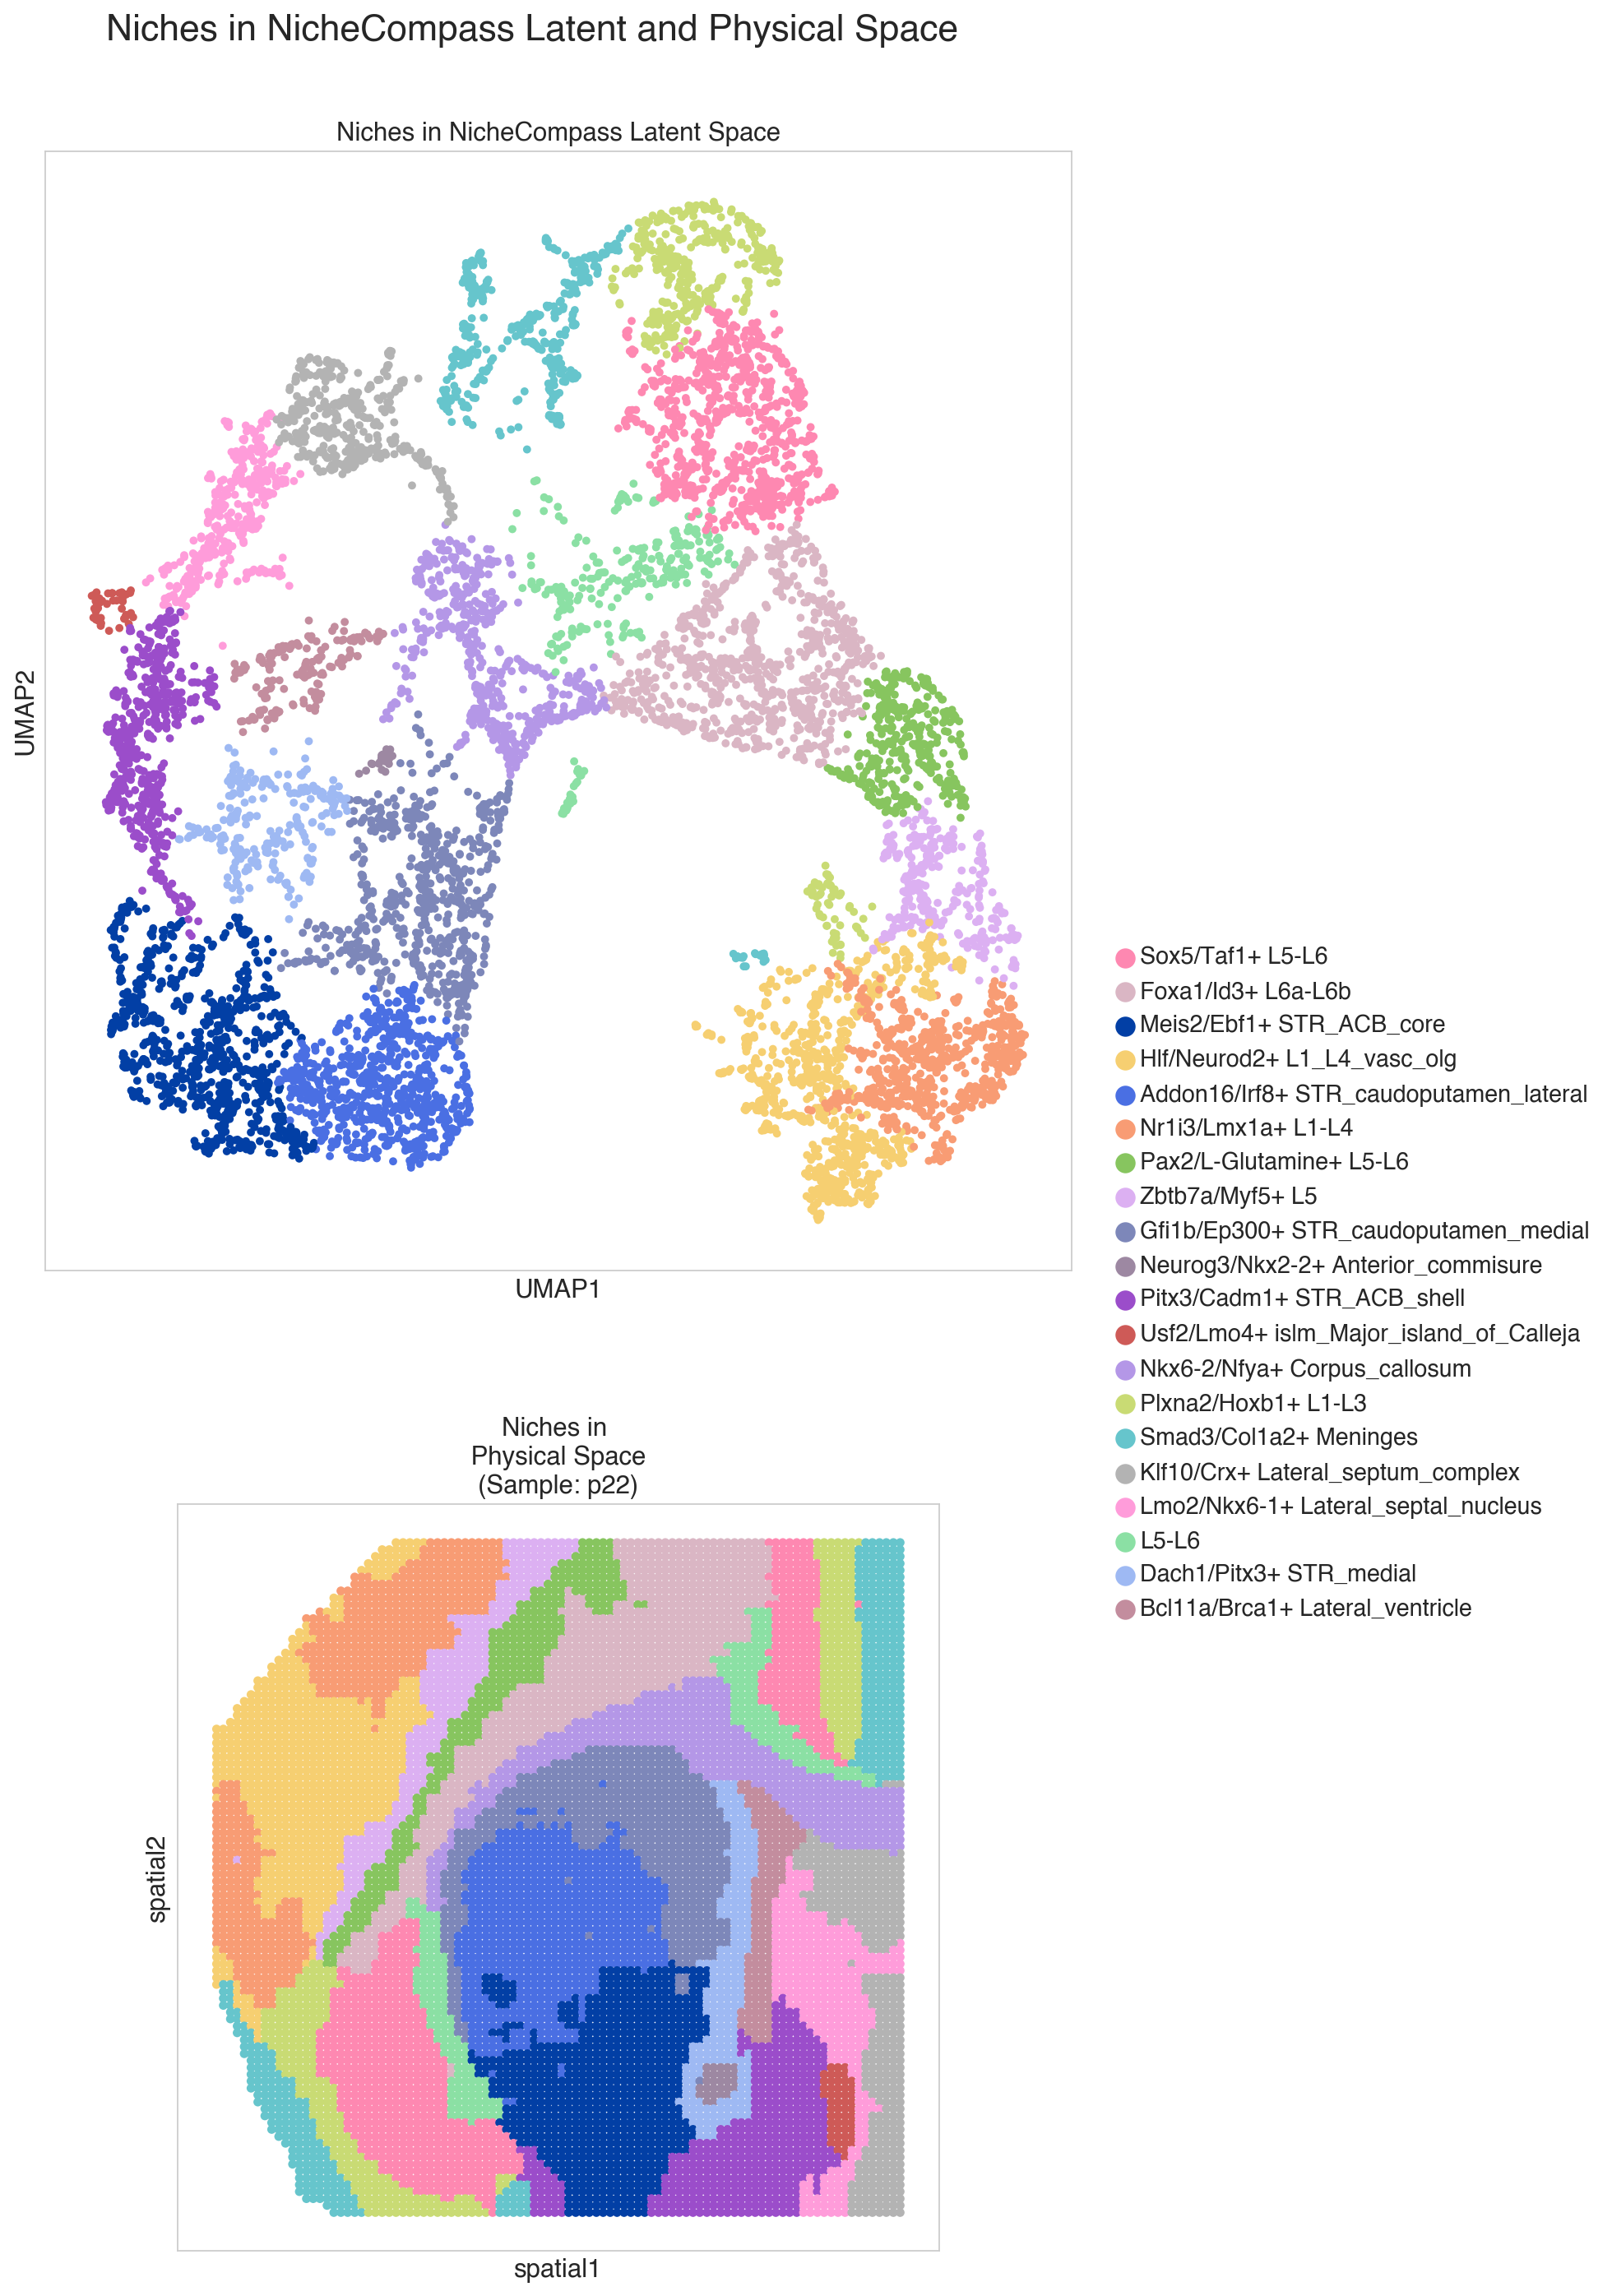

In [17]:
### Supplementary Fig. 24b: Niches ###
sc.tl.leiden(adata=model.adata,
             resolution=latent_leiden_resolution,
             key_added=latent_cluster_key,
             neighbors_key=latent_key)
sc.tl.leiden(adata=model.adata,
             resolution=0.05,
             key_added=latent_cluster_key,
             restrict_to=(latent_cluster_key, ["7"]),
             neighbors_key=latent_key)
sc.tl.leiden(adata=model.adata,
             resolution=0.05,
             key_added=latent_cluster_key,
             restrict_to=(latent_cluster_key, ["8"]),
             neighbors_key=latent_key)
sc.tl.leiden(adata=model.adata,
             resolution=0.05,
             key_added=latent_cluster_key,
             restrict_to=(latent_cluster_key, ["6"]),
             neighbors_key=latent_key)

niche_annotation_dict = {
    "0":"Sox5/Taf1+ L5-L6",
    "1":"Foxa1/Id3+ L6a-L6b",
    "2":"Meis2/Ebf1+ STR_ACB_core",
    "3":"Hlf/Neurod2+ L1_L4_vasc_olg",
    "4":"Addon16/Irf8+ STR_caudoputamen_lateral",
    "5":"Nr1i3/Lmx1a+ L1-L4",
    "6,0":"Pax2/L-Glutamine+ L5-L6",
    "6,1":"Zbtb7a/Myf5+ L5",
    "7,0":"Gfi1b/Ep300+ STR_caudoputamen_medial",
    "7,1":"Neurog3/Nkx2-2+ Anterior_commisure",
    "8,0":"Pitx3/Cadm1+ STR_ACB_shell",
    "8,1":"Usf2/Lmo4+ islm_Major_island_of_Calleja",
    "9":"Nkx6-2/Nfya+ Corpus_callosum",
    "10":"Plxna2/Hoxb1+ L1-L3",
    "11":"Smad3/Col1a2+ Meninges",
    "12":"Klf10/Crx+ Lateral_septum_complex",
    "13":"Lmo2/Nkx6-1+ Lateral_septal_nucleus",
    "14":"L5-L6",
    "15":"Dach1/Pitx3+ STR_medial",
    "16":"Bcl11a/Brca1+ Lateral_ventricle"}

model.adata.obs["niche"] = model.adata.obs[latent_cluster_key].map(niche_annotation_dict)

latent_cluster_colors = create_new_color_dict(
    adata=model.adata,
    cat_key=latent_cluster_key)
latent_cluster_colors["7,0"] = "#7d87b9"
latent_cluster_colors["4"] = "#4a6fe3"
latent_cluster_colors["2"] = "#023fa5"
latent_cluster_colors["1"] = "#DAB6C4"
latent_cluster_colors["15"] = "#9EB9F3"
latent_cluster_colors["7,1"] = "#9D88A2"
latent_cluster_colors["13"] = "#FF9CDA"
latent_cluster_colors["8,1"] = "#CE5A57"
niche_colors = {niche: latent_cluster_colors[cluster] for cluster, niche in niche_annotation_dict.items()}

model.adata.obs["niche_abr"] = model.adata.obs["niche"].apply(lambda x: x.split("GP+ ")[1].replace(" ", "\n") if "GP+ " in x else x)

niche_abreviated_colors = {}
for key, value in niche_colors.items():
    if "GP+ " in key:
        niche_abreviated_colors[key.split("GP+ ")[1].replace(" ", "\n")] = value
    else:
        niche_abreviated_colors[key] = value
        
save_fig = True
file_path = f"{figure_folder_path}/res_{latent_leiden_resolution}_" \
            "niches_latent_physical_space.svg"

plot_category_in_latent_and_physical_space(
    adata=model.adata,
    plot_label="Niches",
    cat_key="niche",
    groups=None,
    sample_key=sample_key,
    samples=samples,
    cat_colors=niche_colors,
    size=(720000 / len(model.adata)),
    spot_size=spot_size,
    save_fig=save_fig,
    file_path=file_path)

In [19]:
figure_folder_path

'../../artifacts/spatial_atac_rna_seq_mouse_brain_batch2/figures/reference/13092023_174230'

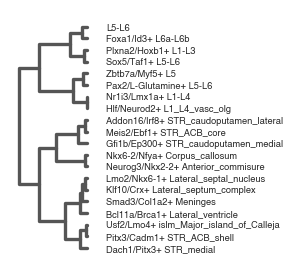

In [23]:
### Supplementary Fig. 24c: Tissue niche hierarchy ###
sc.tl.dendrogram(adata=model.adata,
                 use_rep="nichecompass_latent",
                 linkage_method="ward",
                 groupby="niche")

fig, (ax) = plt.subplots(1, 1, figsize=(0.6, 2))
sc.pl.dendrogram(
    adata=model.adata,
    groupby="niche",
    orientation="left",
    ax=ax,
    save="_nichecompass_latent.svg")
plt.show()
if os.path.exists(f"{figure_folder_path}/dendrogram_nichecompass_latent.svg"):
    os.remove(f"{figure_folder_path}/dendrogram_nichecompass_latent.svg")
shutil.move(f"./figures/dendrogram_nichecompass_latent.svg", figure_folder_path)
shutil.rmtree("./figures/")

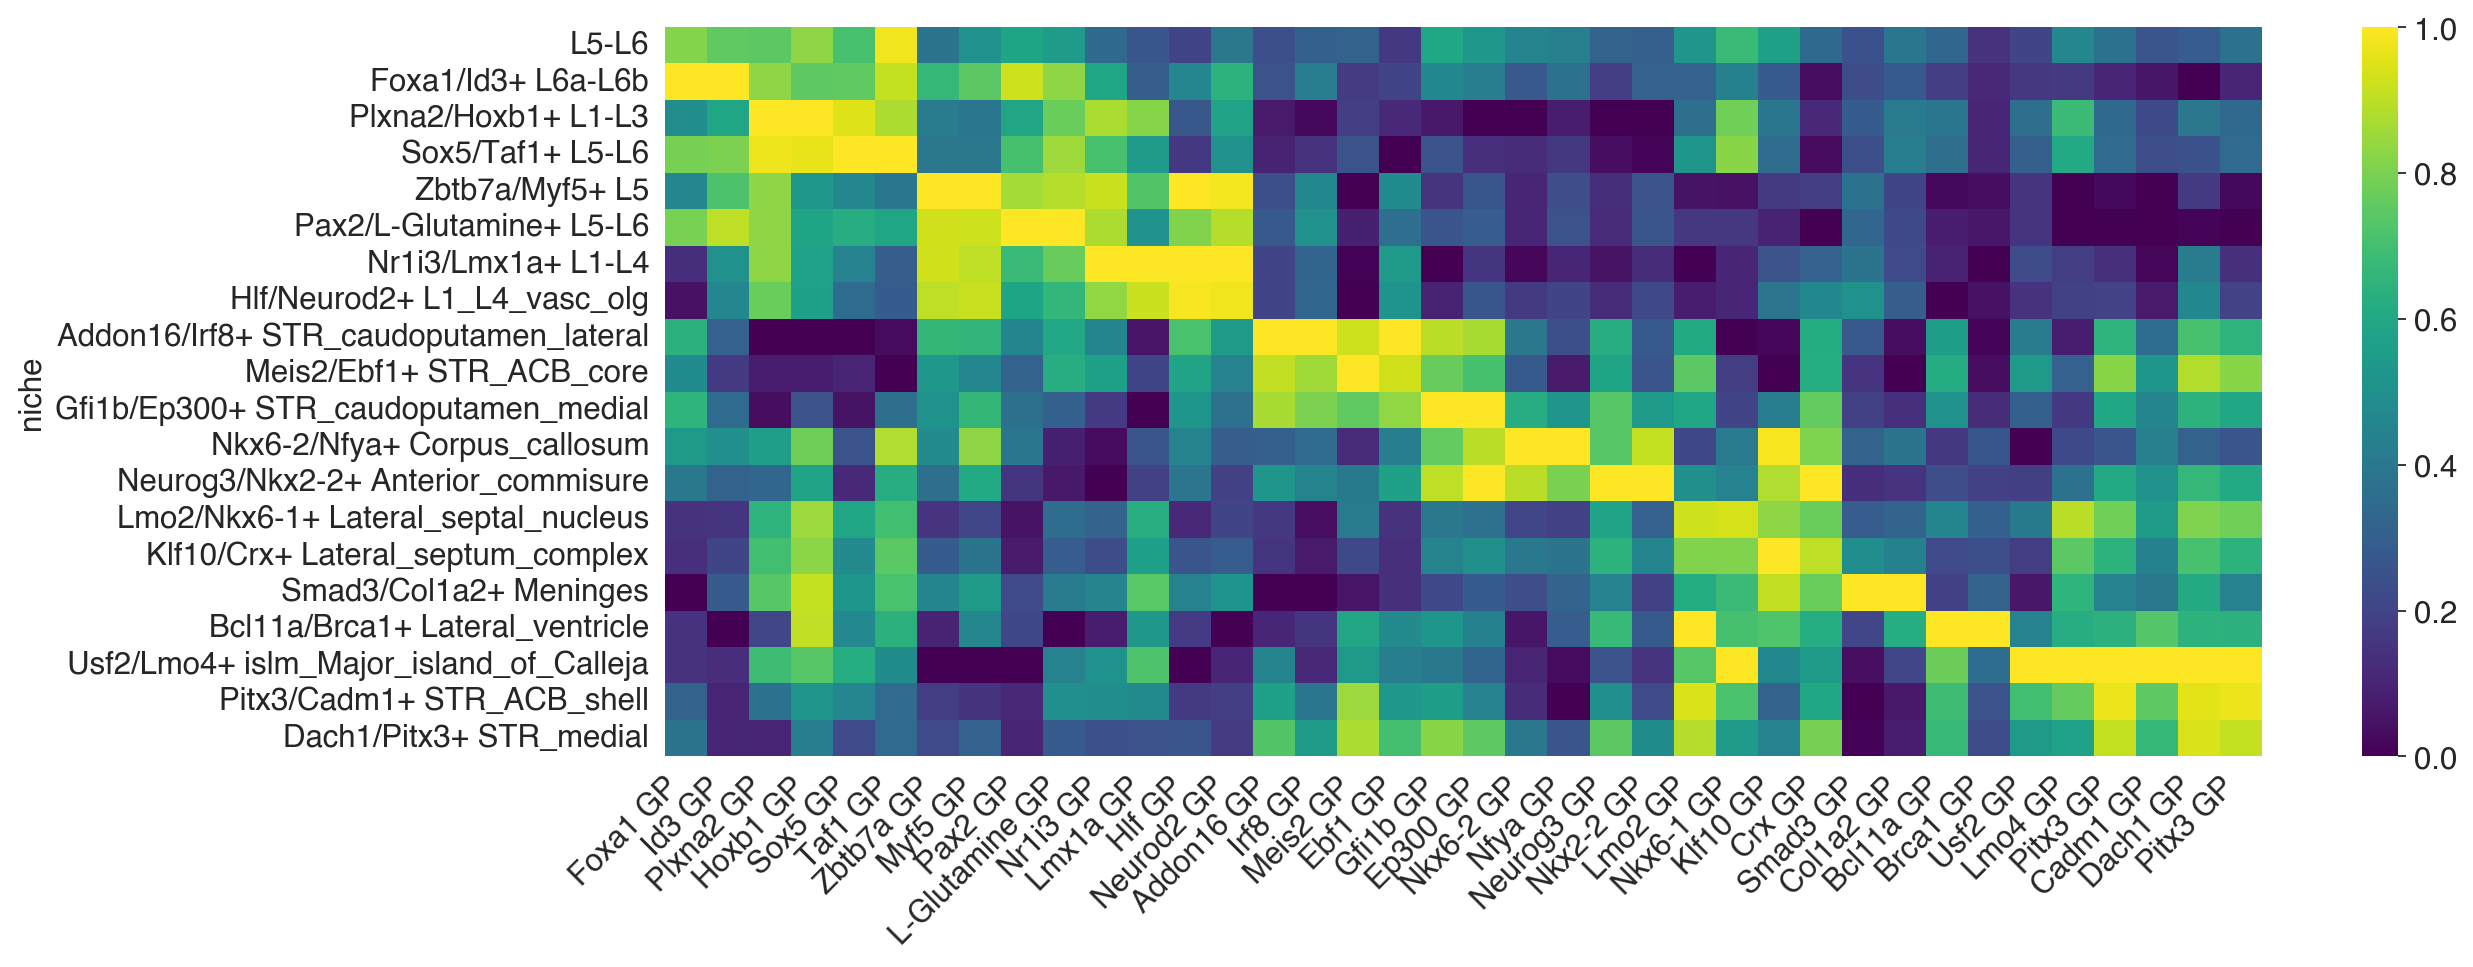

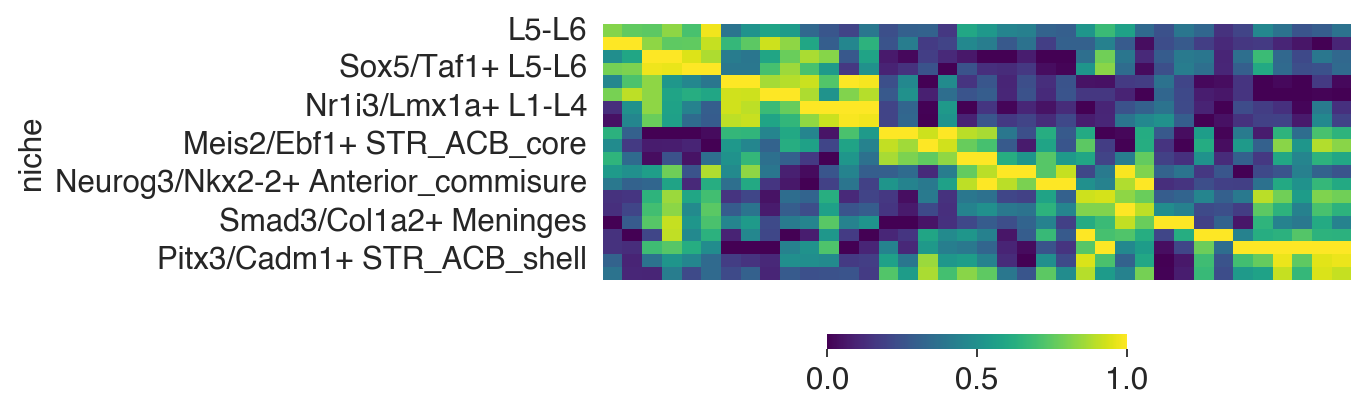

In [24]:
### Supplementary Fig. 24d: Niche-enriched gene programs ###
gp_resign = True # True

gps = [ 
    "Foxa1_TF_target_genes_GP", "Id3_TF_target_genes_GP",
    "Plxna2_ligand_receptor_target_gene_GP", "Hoxb1_TF_target_genes_GP",
    "Sox5_TF_target_genes_GP", "Taf1_TF_target_genes_GP", # Xanthine_metabolite_enzyme_sensor_GP    
    "Zbtb7a_TF_target_genes_GP", "Myf5_TF_target_genes_GP",
    "Pax2_TF_target_genes_GP", "L-Glutamine_metabolite_enzyme_sensor_GP",
    "Nr1i3_TF_target_genes_GP", "Lmx1a_TF_target_genes_GP",
    "Hlf_TF_target_genes_GP", "Neurod2_TF_target_genes_GP",
    "Add-on_16_GP", "Irf8_TF_target_genes_GP",
    "Meis2_TF_target_genes_GP", "Ebf1_TF_target_genes_GP",
    "Gfi1b_TF_target_genes_GP", "Ep300_TF_target_genes_GP",
    "Nkx6-2_TF_target_genes_GP", "Nfya_TF_target_genes_GP",
    "Neurog3_TF_target_genes_GP", "Nkx2-2_TF_target_genes_GP",
    "Lmo2_TF_target_genes_GP", "Nkx6-1_TF_target_genes_GP",
    "Klf10_TF_target_genes_GP", "Crx_TF_target_genes_GP",
    "Smad3_TF_target_genes_GP", "Col1a2_ligand_receptor_target_gene_GP",
    "Bcl11a_TF_target_genes_GP", "Brca1_TF_target_genes_GP", # Draxin_ligand_receptor_target_gene_GP
    "Usf2_TF_target_genes_GP", "Lmo4_TF_target_genes_GP",
    "Pitx3_TF_target_genes_GP", "Cadm1_ligand_receptor_target_gene_GP",
    "Dach1_TF_target_genes_GP", "Pitx3_TF_target_genes_GP",
]

resign_gps = [
    "Taf1_TF_target_genes_GP",
    "Zbtb7a_TF_target_genes_GP",
    "Meis2_TF_target_genes_GP",
    "Ebf1_TF_target_genes_GP",
    "Neurod2_TF_target_genes_GP",
    "Nr1i3_TF_target_genes_GP",
    "Hlf_TF_target_genes_GP",
    "L-Glutamine_metabolite_enzyme_sensor_GP",
    "Gfi1b_TF_target_genes_GP",
    "Ep300_TF_target_genes_GP",
    "Pitx3_TF_target_genes_GP",
    "Cadm1_ligand_receptor_target_gene_GP",
    "Usf2_TF_target_genes_GP",
    "Lmo4_TF_target_genes_GP",
    "Rps19_ligand_receptor_target_gene_GP",
    "Nfya_TF_target_genes_GP",
    "Nkx6-2_TF_target_genes_GP",
    "Lmo2_TF_target_genes_GP",
    "Pitx3_TF_target_genes_GP",
    "Brca1_TF_target_genes_GP",
    "Bcl11a_TF_target_genes_GP",
    "Nkx6-1_TF_target_genes_GP",
    "Klf10_TF_target_genes_GP",
    "Dach1_TF_target_genes_GP",
    "Pitx3_TF_target_genes_GP"]

if gp_resign:
    for gp in resign_gps:
        model.adata.obs[gp] = -1 * model.adata.obs[gp]

df = model.adata.obs[["niche"] + gps].groupby("niche").mean()
df = df.reindex(model.adata.uns["dendrogram_niche"]["categories_ordered"][::-1])

scaler = MinMaxScaler()
normalized_columns = scaler.fit_transform(df)
normalized_df = pd.DataFrame(normalized_columns, columns=df.columns)
normalized_df.index = df.index
normalized_df.columns = [col.split("_lig")[0].split("_met")[0].split("_TF")[0].replace("Add-on_16_GP", "Addon16").replace("_acid", " acid") + " GP" for col in normalized_df.columns]

plt.figure(figsize=(16, 6))  # Set the figure size
ax = sns.heatmap(normalized_df,
            cmap='viridis',
            annot=False,
            linewidths=0)
plt.xticks(rotation=45,
           ha="right"
          )
plt.savefig(f"{figure_folder_path}/enriched_gps_heatmap.svg",
            bbox_inches="tight")

plt.figure(figsize=(6, 3))  # Set the figure size
ax = sns.heatmap(normalized_df,
            cmap='viridis',
            annot=False,
            linewidths=0,
            cbar_kws={"orientation": "horizontal", "location": "bottom", "shrink": 0.4})
plt.xticks([])
plt.savefig(f"{figure_folder_path}/heatmap_colorbar.svg",
            bbox_inches="tight")

In [28]:
### Supplementary Fig. 24e: Niche composition ###
cell_type_colors = create_new_color_dict(
    adata=model.adata,
    color_palette=("cell_type_30"),
    cat_key=cell_type_key)
cell_type_colors["CA3GL"] = "#1f77b4"
cell_type_colors["D1MSN"] = "#ff7f0e"
cell_type_colors["LSXGA"] = "#279e68"
cell_type_colors["MXD"] = "#d62728"
cell_type_colors["STRGA"] = "#aa40fc"

tmp = pd.crosstab(model.adata.obs["niche"], model.adata.obs[cell_type_key], normalize='index')
tmp = tmp.reindex(model.adata.uns["dendrogram_niche"]["categories_ordered"][::])
ax = tmp.plot.barh(color=cell_type_colors, stacked=True, figsize=(4, 6)).legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xlabel("Cell Type Proportions")
plt.savefig(f"{figure_folder_path}/niche_cell_type_proportions.svg", bbox_inches='tight')

KeyError: 'celltype'

In [ ]:
sc.tl.dendrogram(adata=model.adata,
                     var_names=gps,
                     linkage_method="single",
                     groupby="niche")

fig, (ax) = plt.subplots(1, 1, figsize=(3, 8))
sc.pl.dendrogram(
    adata=model.adata,
    groupby="niche",
    orientation="left",
    ax=ax)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(17, 21))
sankey(
    x=model.adata.obs[cell_type_key],
    y=model.adata.obs["niche_abr"],
    title="Cell Type to Niche Mapping",
    title_left="Cell Type",
    title_right="Niche",
    ax=ax,
    fontsize="16",  # "xx-small",
    #left_order=model.adata.obs[cell_type_key].unique().tolist(),
    colors=cell_type_colors,
    alpha=0.5)
plt.tight_layout()
plt.savefig(f"{figure_folder_path}/sankey_cell_type_to_niche.svg")
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(17, 21))
sankey(
    x=model.adata.obs[atac_cluster_key],
    y=model.adata.obs["niche_abr"],
    title="ATAC Cluster to Niche Mapping",
    title_left="Annotated ATAC Cluster",
    title_right="Niche",
    ax=ax,
    fontsize="16",  # "xx-small",
    #left_order=model.adata.obs[cell_type_key].unique().tolist(),
    colors=atac_cluster_colors,
    alpha=0.5)
plt.tight_layout()
plt.savefig(f"{figure_folder_path}/sankey_atac_cluster_to_niche.svg")
plt.show()

In [ ]:
adata_all_genes = sc.read_h5ad(f"{srt_data_gold_folder_path}/spatial_atac_rna_seq_mouse_brain_batch2.h5ad")
fig, axs = plt.subplots(nrows=2,
                        ncols=2,
                        figsize=(15, 15))

# Lmo4 TF & Target Gene Peaks
color_map = "RdPu"
sc.pl.spatial(
    adata=adata_all_genes,
    color="Drd3",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Drd3",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 0],
    show=False)

plt.show()
fig.savefig(f"{figure_folder_path}/drd3_expression.svg",
            bbox_inches="tight")
del(adata_all_genes)

In [ ]:
fig, axs = plt.subplots(nrows=2,
                            ncols=2,
                            figsize=(15, 15))

# Lmo4 TF & Target Gene Peaks
color_map = "RdGy_r"
sc.pl.spatial(
    adata=model.adata,
    color="Lmo4_TF_target_genes_GP",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Lmo4",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 0],
    show=False)    
color_map = "RdPu"
sc.pl.spatial(
    adata=model.adata,
    color="Lmo4",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Lmo4",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 1],
    show=False)

sc.pl.spatial(
    adata=model.adata_atac,
    color="chr11:70029079-70029942",
    use_raw=False,
    color_map=color_map,
    spot_size=spot_size,
    title=f"chr11:70029079-70029942",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[1, 0],
    show=False)
sc.pl.spatial(
    adata=model.adata_atac,
    color="chr11:70021137-70021886",
    use_raw=False,
    color_map=color_map,
    spot_size=spot_size,
    title="chr11:70021137-70021886",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[1, 1],
    show=False)

plt.show()
fig.savefig(f"{figure_folder_path}/lmo4_gp_genes_peaks.svg",
            bbox_inches="tight")

In [ ]:
fig, axs = plt.subplots(nrows=6,
                            ncols=2,
                            figsize=(25, 25))

# Lmo4 TF & Target Gene Peaks
color_map = "RdGy_r"
sc.pl.spatial(
    adata=model.adata,
    color="Add-on_16_GP",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Add-on 16",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 0],
    show=False)    
color_map = "RdPu"
sc.pl.spatial(
    adata=model.adata,
    color="Scn4b",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Scn4b",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 1],
    show=False)

sc.pl.spatial(
    adata=model.adata,
    color="Gm17428",
    use_raw=False,
    color_map=color_map,
    spot_size=spot_size,
    title=f"Gm17428",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[1, 0],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Rgs9",
    use_raw=False,
    color_map=color_map,
    spot_size=spot_size,
    title="Rgs9",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[1, 1],
    show=False)

sc.pl.spatial(
    adata=model.adata,
    color="Sh3rf2",
    use_raw=False,
    color_map=color_map,
    spot_size=spot_size,
    title="Sh3rf2",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[2, 0],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Syndig1l",
    use_raw=False,
    color_map=color_map,
    spot_size=spot_size,
    title="Syndig1l",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[2, 1],
    show=False)

sc.pl.spatial(
    adata=model.adata_atac,
    color="chr3:65228350-65229095",
    use_raw=False,
    color_map=color_map,
    spot_size=spot_size,
    title=f"chr3:65228350-65229095",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[3, 0],
    show=False)
sc.pl.spatial(
    adata=model.adata_atac,
    color="chr8:63129065-63129762",
    use_raw=False,
    color_map=color_map,
    spot_size=spot_size,
    title="chr8:63129065-63129762",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[3, 1],
    show=False)

sc.pl.spatial(
    adata=model.adata_atac,
    color="chr8:108813542-108814304",
    use_raw=False,
    color_map=color_map,
    spot_size=spot_size,
    title="chr8:108813542-108814304",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[4, 0],
    show=False)
sc.pl.spatial(
    adata=model.adata_atac,
    color="chr14:29539717-29540617",
    use_raw=False,
    color_map=color_map,
    spot_size=spot_size,
    title="chr14:29539717-29540617",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[4, 1],
    show=False)

sc.pl.spatial(
    adata=model.adata_atac,
    color="chr13:54093213-54094097",
    use_raw=False,
    color_map=color_map,
    spot_size=spot_size,
    title="chr13:54093213-54094097",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[5, 0],
    show=False)

plt.show()
fig.savefig(f"{figure_folder_path}/addon16_gp_genes_peaks.svg",
            bbox_inches="tight")

In [ ]:
fig, axs = plt.subplots(nrows=4,
                            ncols=2,
                            figsize=(15, 15))

model.adata.obs["Rps19_ligand_receptor_target_gene_GP_sign_corrected"] = -1 *  model.adata.obs["Rps19_ligand_receptor_target_gene_GP"]

# Lmo4 TF & Target Gene Peaks
color_map = "RdGy_r"
sc.pl.spatial(
    adata=model.adata,
    color="Rps19_ligand_receptor_target_gene_GP",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Rps19 GP",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 0],
    show=False)    
color_map = "RdPu"
sc.pl.spatial(
    adata=model.adata,
    color="Rps19",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Rps19",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 1],
    show=False)

sc.pl.spatial(
    adata=model.adata,
    color="Cd82",
    use_raw=False,
    color_map=color_map,
    spot_size=spot_size,
    title=f"Cd82",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[1, 0],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Scd2",
    use_raw=False,
    color_map=color_map,
    spot_size=spot_size,
    title="Scd2",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[1, 1],
    show=False)

sc.pl.spatial(
    adata=model.adata,
    color="Ndrg1",
    use_raw=False,
    color_map=color_map,
    spot_size=spot_size,
    title=f"Ndrg1",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[2, 0],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Mical2",
    use_raw=False,
    color_map="YlOrBr",
    spot_size=spot_size,
    title=f"Mical2",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[2, 1],
    show=False)    

sc.pl.spatial(
    adata=model.adata,
    color="Enpp2",
    use_raw=False,
    color_map=color_map,
    spot_size=spot_size,
    title="Enpp2",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[3, 0],
    show=False)

plt.show()
fig.savefig(f"{figure_folder_path}/rps19_gp_genes.svg",
            bbox_inches="tight")

In [ ]:
fig, axs = plt.subplots(nrows=3,
                            ncols=2,
                            figsize=(15, 15))

# Lmo4 TF & Target Gene Peaks
color_map = "RdGy_r"
sc.pl.spatial(
    adata=model.adata,
    color="Usf2_TF_target_genes_GP",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Usf2 GP",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 0],
    show=False)    
color_map = "RdPu"
sc.pl.spatial(
    adata=model.adata,
    color="Prkar2b",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Prkar2b",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 1],
    show=False)

sc.pl.spatial(
    adata=model.adata,
    color="Apc",
    use_raw=False,
    color_map=color_map,
    spot_size=spot_size,
    title=f"Apc",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[1, 0],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Pou2f1",
    use_raw=False,
    color_map=color_map,
    spot_size=spot_size,
    title="Pou2f1",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[1, 1],
    show=False)

sc.pl.spatial(
    adata=model.adata_atac,
    color="chr18:34247310-34248119",
    use_raw=False,
    color_map=color_map,
    spot_size=spot_size,
    title=f"chr18:34247310-34248119",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[2, 0],
    show=False)
sc.pl.spatial(
    adata=model.adata_atac,
    color="chr1:165934747-165935645",
    use_raw=False,
    color_map=color_map,
    spot_size=spot_size,
    title=f"chr1:165934747-165935645",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[2, 1],
    show=False)    

plt.show()
fig.savefig(f"{figure_folder_path}/usf2_gp_genes.svg",
            bbox_inches="tight")


In [ ]:
fig, axs = plt.subplots(nrows=3,
                        ncols=2,
                        figsize=(20, 15))

# L-Glutamine_metabolite_enzyme_sensor_GP
color_map = "RdGy_r"
sc.pl.spatial(
    adata=model.adata,
    color="L-Glutamine_metabolite_enzyme_sensor_GP",
    color_map=color_map,
    spot_size=spot_size,
    title=f"L-Glutamine_metabolite_enzyme_sensor_GP",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 0],
    show=False)    
color_map = "RdPu"
# Sensor
sc.pl.spatial(
    adata=model.adata,
    color="Slc38a2",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Slc38a2",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 1],
    show=False)

# Sensor
sc.pl.spatial(
    adata=model.adata,
    color="Slc38a1",
    use_raw=False,
    color_map=color_map,
    spot_size=spot_size,
    title=f"Slc38a1",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[1, 0],
    show=False)
# Enzyme
sc.pl.spatial(
    adata=model.adata,
    color="Gls",
    use_raw=False,
    color_map=color_map,
    spot_size=spot_size,
    title="Gls",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[1, 1],
    show=False)

# Enzyme
sc.pl.spatial(
    adata=model.adata,
    color="Glul",
    use_raw=False,
    color_map=color_map,
    spot_size=spot_size,
    title="Glul",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[2, 0],
    show=False)
# Enzyme
sc.pl.spatial(
    adata=model.adata,
    color="Gmps",
    use_raw=False,
    color_map=color_map,
    spot_size=spot_size,
    title="Gmps",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[2, 1],
    show=False)

plt.show()
fig.savefig(f"{figure_folder_path}/l-glutamine_gp_genes.svg",
            bbox_inches="tight")


In [ ]:
fig, axs = plt.subplots(nrows=3,
                        ncols=2,
                        figsize=(20, 15))

# L-Aspartic_acid_metabolite_enzyme_sensor_GP
color_map = "RdGy_r"
sc.pl.spatial(
    adata=model.adata,
    color="Add-on_89_GP",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Add-on_89_GP",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 0],
    show=False)    
color_map = "RdPu"
sc.pl.spatial(
    adata=model.adata,
    color="Mobp",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Mobp",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 1],
    show=False)

sc.pl.spatial(
    adata=model.adata,
    color="Tspan2",
    use_raw=False,
    color_map=color_map,
    spot_size=spot_size,
    title=f"Tspan2",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[1, 0],
    show=False)

plt.show()
fig.savefig(f"{figure_folder_path}/addon89_gp_genes.svg",
            bbox_inches="tight")

In [ ]:
network_df = compute_communication_gp_network(
    gp_list=["Rps19_ligand_receptor_target_gene_GP", "L-Glutamine_metabolite_enzyme_sensor_GP"],
    model=model,
    group_key="niche_abr", # celltype
    n_neighbors=90)

rps_network_df = network_df[network_df["edge_type"] == "Rps19_ligand_receptor_target_gene_GP"]
lglutamine_network_df = network_df[network_df["edge_type"] == "L-Glutamine_metabolite_enzyme_sensor_GP"]

visualize_communication_gp_network(
    adata=model.adata,
    network_df=rps_network_df,
    figsize=(14, 8),
    cat_colors=niche_abreviated_colors,
    edge_type_colors=["#1f77b4"], 
    cat_key="niche_abr",
    save=True,
    save_path=f"{figure_folder_path}/gp_network_rps.svg",
    )

visualize_communication_gp_network(
adata=model.adata,
network_df=lglutamine_network_df,
figsize=(15, 7),
cat_colors=niche_abreviated_colors,
edge_type_colors=["#ff7f0e"],
cat_key="niche_abr",
save=True,
save_path=f"{figure_folder_path}/gp_network_lglutamine.svg",
)

In [ ]:
model.model.features_idx_dict_["target_reconstructed_rna_idx"] = np.sort(np.concatenate((model.model.features_idx_dict_["target_masked_rna_idx"], model.model.features_idx_dict_["target_unmasked_rna_idx"])))
model.model.features_idx_dict_["source_reconstructed_rna_idx"] = np.sort(np.concatenate((model.model.features_idx_dict_["source_masked_rna_idx"], model.model.features_idx_dict_["source_unmasked_rna_idx"])))
model.model.features_idx_dict_["target_reconstructed_atac_idx"] = np.sort(np.concatenate((model.model.features_idx_dict_["target_masked_atac_idx"], model.model.features_idx_dict_["target_unmasked_atac_idx"])))
model.model.features_idx_dict_["source_reconstructed_atac_idx"] = np.sort(np.concatenate((model.model.features_idx_dict_["source_masked_atac_idx"], model.model.features_idx_dict_["source_unmasked_atac_idx"])))

output = model.get_omics_decoder_outputs(
                adata=model.adata,
                only_active_gps=True,
                node_batch_size=2048)

target_genes = ["Lmo4", "Gm17428", "Rgs9", "Sh3rf2", "Syndig1l", "Cd82", "Scd2", "Ndrg1", "Mical2", "Enpp2", "Slc1a2"]
for gene in target_genes:
    model.adata.obs[f"{gene}_rec"] = output["target_rna_nb_means"][:, model.adata.var_names.tolist().index(gene)]

source_genes = ["Scn4b", "Aspa", "Asrgl1", "Prkar2b", "Apc", "Pou2f1", "Rps19"]
for gene in source_genes:
    model.adata.obs[f"{gene}_rec"] = output["source_rna_nb_means"][:, model.adata.var_names.tolist().index(gene)]

target_peaks = ["chr8:63129065-63129762"]
for peak in target_peaks:
    model.adata_atac.obs[f"{peak}_rec"] = output["target_atac_nb_means"][:, model.adata_atac.var_names.tolist().index(peak)]

source_peaks = ["chr18:34247310-34248119", "chr1:165934747-165935645", "chr3:65228350-65229095", "chr8:108813542-108814304", "chr14:29539717-29540617", "chr13:54093213-54094097", "chr11:70029079-70029942", "chr11:70021137-70021886"]
for peak in source_peaks:
    model.adata_atac.obs[f"{peak}_rec"] = output["source_atac_nb_means"][:, model.adata_atac.var_names.tolist().index(peak)]

# Reconstructed genes
fig, axs = plt.subplots(nrows=len(target_genes + source_genes),
                        ncols=1,
                        figsize=(10, 10 * len(target_genes + source_genes)))

color_map = "RdPu"
for i, gene in enumerate(target_genes + source_genes):
    sc.pl.spatial(
        adata=model.adata,
        color=f"{gene}_rec",
        color_map=color_map,
        spot_size=spot_size,
        title=f"{gene}_rec",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[i],
        show=False)    

plt.show()
fig.savefig(f"{figure_folder_path}/reconstructed_genes.svg",
        bbox_inches="tight")

# Reconstructed peaks
fig, axs = plt.subplots(nrows=len(target_peaks + source_peaks),
                        ncols=1,
                        figsize=(10, 10 * len(target_peaks + source_peaks)))

color_map = "RdPu"
for i, gene in enumerate(target_peaks + source_peaks):
    sc.pl.spatial(
        adata=model.adata_atac,
        color=f"{gene}_rec",
        color_map=color_map,
        spot_size=spot_size,
        title=f"{gene}_rec",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[i],
        show=False)    

plt.show()
fig.savefig(f"{figure_folder_path}/reconstructed_peaks.svg",
            bbox_inches="tight")

In [ ]:
fig, axs = plt.subplots(nrows=5,
                                ncols=2,
                                figsize=(25, 25))

# Add-on 89 GP
color_map = "RdGy_r"
sc.pl.spatial(
    adata=model.adata,
    color="Add-on_89_GP",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Add-on 89",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 0],
    show=False)    
color_map = "RdPu"
sc.pl.spatial(
    adata=model.adata,
    color="Mobp",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Mobp",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 1],
    show=False)

sc.pl.spatial(
    adata=model.adata,
    color="Tspan2",
    use_raw=False,
    color_map=color_map,
    spot_size=spot_size,
    title=f"Tspan2",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[1, 0],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Pllp",
    use_raw=False,
    color_map=color_map,
    spot_size=spot_size,
    title="Pllp",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[1, 1],
    show=False)

sc.pl.spatial(
    adata=model.adata,
    color="Trf",
    use_raw=False,
    color_map=color_map,
    spot_size=spot_size,
    title="Trf",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[2, 0],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Pdlim2",
    use_raw=False,
    color_map=color_map,
    spot_size=spot_size,
    title="Pdlim2",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[2, 1],
    show=False)

sc.pl.spatial(
    adata=model.adata_atac,
    color="chr1:24612403-24613300",
    use_raw=False,
    color_map=color_map,
    spot_size=spot_size,
    title=f"chr1:24612403-24613300",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[3, 0],
    show=False)
sc.pl.spatial(
    adata=model.adata_atac,
    color="chr1:172349675-172350564",
    use_raw=False,
    color_map=color_map,
    spot_size=spot_size,
    title="chr1:172349675-172350564",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[3, 1],
    show=False)


sc.pl.spatial(
    adata=model.adata_atac,
    color="chr4:48629122-48629953",
    use_raw=False,
    color_map=color_map,
    spot_size=spot_size,
    title="chr4:48629122-48629953",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[4, 0],
    show=False)
sc.pl.spatial(
    adata=model.adata_atac,
    color="chr14:54935868-54936644",
    use_raw=False,
    color_map=color_map,
    spot_size=spot_size,
    title="chr14:54935868-54936644",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[4, 1],
    show=False)

plt.show()
fig.savefig(f"{figure_folder_path}/addon89_gp_genes_peaks.svg",
            bbox_inches="tight")

In [ ]:
fig, axs = plt.subplots(nrows=5,
                        ncols=2,
                        figsize=(25, 25))

model.adata.obs["Sfrp1_ligand_receptor_target_gene_GP_sign_corrected"] = -1 * model.adata.obs["Sfrp1_ligand_receptor_target_gene_GP"]

# Sfrp1 GP
color_map = "RdGy_r"
sc.pl.spatial(
    adata=model.adata,
    color="Sfrp1_ligand_receptor_target_gene_GP_sign_corrected",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Sfrp1 GP",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 0],
    show=False)    
color_map = "RdPu"
sc.pl.spatial(
    adata=model.adata,
    color="Sfrp1",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Sfrp1",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 1],
    show=False)

sc.pl.spatial(
    adata=model.adata,
    color="Tpx2",
    use_raw=False,
    color_map=color_map,
    spot_size=spot_size,
    title=f"Tpx2",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[1, 0],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Fzd2",
    use_raw=False,
    color_map=color_map,
    spot_size=spot_size,
    title="Fzd2",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[1, 1],
    show=False)

sc.pl.spatial(
    adata=model.adata,
    color="Palld",
    use_raw=False,
    color_map=color_map,
    spot_size=spot_size,
    title="Palld",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[2, 0],
    show=False)

sc.pl.spatial(
    adata=model.adata_atac,
    color="chr11:102603868-102604697",
    use_raw=False,
    color_map=color_map,
    spot_size=spot_size,
    title=f"chr11:102603868-102604697",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[3, 0],
    show=False)
sc.pl.spatial(
    adata=model.adata_atac,
    color="chr13:99458804-99459599",
    use_raw=False,
    color_map=color_map,
    spot_size=spot_size,
    title="chr13:99458804-99459599",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[3, 1],
    show=False)


sc.pl.spatial(
    adata=model.adata_atac,
    color="chr13:99444371-99445164",
    use_raw=False,
    color_map=color_map,
    spot_size=spot_size,
    title="chr13:99444371-99445164",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[4, 0],
    show=False)
sc.pl.spatial(
    adata=model.adata_atac,
    color="chr13:99514802-99515661",
    use_raw=False,
    color_map=color_map,
    spot_size=spot_size,
    title="chr13:99514802-99515661",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[4, 1],
    show=False)

plt.show()
fig.savefig(f"{figure_folder_path}/sfrp1_gp_genes_peaks.svg",
            bbox_inches="tight")

In [ ]:
fig, axs = plt.subplots(nrows=5,
                        ncols=2,
                        figsize=(25, 25))

# Sfrp1 GP
color_map = "RdGy_r"
sc.pl.spatial(
    adata=model.adata,
    color="Apod_ligand_receptor_target_gene_GP",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Apod GP",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 0],
    show=False)    
color_map = "RdPu"
sc.pl.spatial(
    adata=model.adata,
    color="Apod",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Apod",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 1],
    show=False)

sc.pl.spatial(
    adata=model.adata,
    color="Trp53inp2",
    use_raw=False,
    color_map=color_map,
    spot_size=spot_size,
    title=f"Trp53inp2",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[1, 0],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Ddah2",
    use_raw=False,
    color_map=color_map,
    spot_size=spot_size,
    title="Ddah2",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[1, 1],
    show=False)

sc.pl.spatial(
    adata=model.adata,
    color="Ugt8a",
    use_raw=False,
    color_map=color_map,
    spot_size=spot_size,
    title="Ugt8a",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[2, 0],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Hhip",
    use_raw=False,
    color_map=color_map,
    spot_size=spot_size,
    title="Hhip",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[2, 1],
    show=False)

plt.show()
fig.savefig(f"{figure_folder_path}/apod_gp_genes_peaks.svg",
            bbox_inches="tight")

In [ ]:
fig, axs = plt.subplots(nrows=5,
                        ncols=2,
                        figsize=(25, 25))

model.adata.obs["Cldn11_ligand_receptor_target_gene_GP_sign_corrected"] = -1 * model.adata.obs["Cldn11_ligand_receptor_target_gene_GP"]

# Cldn11 GP
color_map = "RdGy_r"
sc.pl.spatial(
    adata=model.adata,
    color="Cldn11_ligand_receptor_target_gene_GP_sign_corrected",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Cldn11 GP",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 0],
    show=False)    
color_map = "RdPu"
# Ligand & Receptor
sc.pl.spatial(
    adata=model.adata,
    color="Cldn11",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Cldn11",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 1],
    show=False)

# Target Genes
sc.pl.spatial(
    adata=model.adata,
    color="Pde8a",
    use_raw=False,
    color_map=color_map,
    spot_size=spot_size,
    title=f"Pde8a",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[1, 0],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Fzd2",
    use_raw=False,
    color_map=color_map,
    spot_size=spot_size,
    title="Fzd2",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[1, 1],
    show=False)

sc.pl.spatial(
    adata=model.adata,
    color="Pcsk5",
    use_raw=False,
    color_map=color_map,
    spot_size=spot_size,
    title="Pcsk5",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[2, 0],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Ugt8a",
    use_raw=False,
    color_map=color_map,
    spot_size=spot_size,
    title="Ugt8a",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[2, 1],
    show=False)

plt.show()
fig.savefig(f"{figure_folder_path}/cldn11_gp_genes_peaks.svg",
            bbox_inches="tight")

In [ ]:
fig, axs = plt.subplots(nrows=5,
                        ncols=2,
                        figsize=(25, 25))

model.adata.obs["Cadm4_ligand_receptor_target_gene_GP_sign_corrected"] = -1 * model.adata.obs["Cadm4_ligand_receptor_target_gene_GP"]

# Cadm4 GP
color_map = "RdGy_r"
sc.pl.spatial(
    adata=model.adata,
    color="Cadm4_ligand_receptor_target_gene_GP_sign_corrected",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Cadm4 GP",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 0],
    show=False)    
color_map = "RdPu"
# Ligand
sc.pl.spatial(
    adata=model.adata,
    color="Cadm4",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Cadm4",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 1],
    show=False)

# Receptors
sc.pl.spatial(
    adata=model.adata,
    color="Mag",
    use_raw=False,
    color_map=color_map,
    spot_size=spot_size,
    title=f"Mag",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[1, 0],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Cadm2",
    use_raw=False,
    color_map=color_map,
    spot_size=spot_size,
    title="Cadm2",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[1, 1],
    show=False)

# Target genes
sc.pl.spatial(
    adata=model.adata,
    color="Fnbp1",
    use_raw=False,
    color_map=color_map,
    spot_size=spot_size,
    title="Fnbp1",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[2, 0],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Scd2",
    use_raw=False,
    color_map=color_map,
    spot_size=spot_size,
    title="Scd2",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[2, 1],
    show=False)

plt.show()
fig.savefig(f"{figure_folder_path}/cadm4_gp_genes_peaks.svg",
            bbox_inches="tight")

In [ ]:
fig, axs = plt.subplots(nrows=5,
                        ncols=2,
                        figsize=(25, 25))

model.adata.obs["Glycine_metabolite_enzyme_sensor_GP_sign_corrected"] = -1 * model.adata.obs["Glycine_metabolite_enzyme_sensor_GP"]

# Glycine GP
color_map = "RdGy_r"
sc.pl.spatial(
    adata=model.adata,
    color="Glycine_metabolite_enzyme_sensor_GP_sign_corrected",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Glycine GP",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 0],
    show=False)    
color_map = "RdPu"
# Enzymes
sc.pl.spatial(
    adata=model.adata,
    color="Lap3",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Lap3",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 1],
    show=False)

sc.pl.spatial(
    adata=model.adata,
    color="Gatm",
    use_raw=False,
    color_map=color_map,
    spot_size=spot_size,
    title=f"Gatm",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[1, 0],
    show=False)

# Sensor
sc.pl.spatial(
    adata=model.adata,
    color="Grin1",
    use_raw=False,
    color_map=color_map,
    spot_size=spot_size,
    title="Grin1",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[1, 1],
    show=False)

plt.show()
fig.savefig(f"{figure_folder_path}/glycine_gp_genes_peaks.svg",
            bbox_inches="tight")

In [ ]:
fig, axs = plt.subplots(nrows=5,
                        ncols=2,
                        figsize=(25, 25))

model.adata.obs["Cd82_ligand_receptor_target_gene_GP_sign_corrected"] = -1 * model.adata.obs["Cd82_ligand_receptor_target_gene_GP"]

# Cd82 GP
color_map = "RdGy_r"
sc.pl.spatial(
    adata=model.adata,
    color="Cd82_ligand_receptor_target_gene_GP_sign_corrected",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Cd82 GP",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 0],
    show=False)    
color_map = "RdPu"
# Ligand
sc.pl.spatial(
    adata=model.adata,
    color="Cd82",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Cd82",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 1],
    show=False)

# Target genes
sc.pl.spatial(
    adata=model.adata,
    color="Gsn",
    use_raw=False,
    color_map=color_map,
    spot_size=spot_size,
    title=f"Gsn",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[1, 0],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Gfra1",
    use_raw=False,
    color_map=color_map,
    spot_size=spot_size,
    title="Gfra1",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[1, 1],
    show=False)

sc.pl.spatial(
    adata=model.adata,
    color="Tcf7l2",
    use_raw=False,
    color_map=color_map,
    spot_size=spot_size,
    title="Tcf7l2",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[2, 0],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Zfp36l1",
    use_raw=False,
    color_map=color_map,
    spot_size=spot_size,
    title="Zfp36l1",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[2, 1],
    show=False)

plt.show()
fig.savefig(f"{figure_folder_path}/cd82_gp_genes_peaks.svg",
            bbox_inches="tight")

In [ ]:
fig, axs = plt.subplots(nrows=5,
                        ncols=2,
                        figsize=(25, 25))

# Nfasc GP
color_map = "RdGy_r"
sc.pl.spatial(
    adata=model.adata,
    color="Nfasc_ligand_receptor_target_gene_GP",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Nfasc GP",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 0],
    show=False)    
color_map = "RdPu"
# Ligand
sc.pl.spatial(
    adata=model.adata,
    color="Nfasc",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Nfasc",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 1],
    show=False)

# Target genes
sc.pl.spatial(
    adata=model.adata,
    color="Mgll",
    use_raw=False,
    color_map=color_map,
    spot_size=spot_size,
    title=f"Mgll",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[1, 0],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Enpp2",
    use_raw=False,
    color_map=color_map,
    spot_size=spot_size,
    title="Enpp2",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[1, 1],
    show=False)

plt.show()
fig.savefig(f"{figure_folder_path}/nfasc_gp_genes_peaks.svg",
            bbox_inches="tight")

In [ ]:
fig, axs = plt.subplots(nrows=5,
                        ncols=2,
                        figsize=(25, 25))

model.adata.obs["Nfib_TF_target_genes_GP_sign_corrected"] = -1 * model.adata.obs["Nfib_TF_target_genes_GP"]

# Nfib GP
color_map = "RdGy_r"
sc.pl.spatial(
    adata=model.adata,
    color="Nfib_TF_target_genes_GP_sign_corrected",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Nfib GP",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 0],
    show=False)    
color_map = "RdPu"
# TF
sc.pl.spatial(
    adata=model.adata,
    color="Nfib",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Nfib",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 1],
    show=False)

# Target gene
sc.pl.spatial(
    adata=model.adata,
    color="Nfix",
    use_raw=False,
    color_map=color_map,
    spot_size=spot_size,
    title=f"Nfix",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[1, 0],
    show=False)
plt.show()
fig.savefig(f"{figure_folder_path}/nfib_gp_genes_peaks.svg",
            bbox_inches="tight")

In [ ]:
fig, axs = plt.subplots(nrows=2,
                        ncols=2,
                        figsize=(25, 25))

model.adata.obs["Vdr_TF_target_genes_GP_sign_corrected"] = -1 * model.adata.obs["Vdr_TF_target_genes_GP"]

# Vdr GP
color_map = "RdGy_r"
sc.pl.spatial(
    adata=model.adata,
    color="Vdr_TF_target_genes_GP_sign_corrected",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Vdr GP",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 0],
    show=False)    
color_map = "RdPu"
# Target gene
sc.pl.spatial(
    adata=model.adata,
    color="Tpt1",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Tpt1",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 1],
    show=False)

plt.show()
fig.savefig(f"{figure_folder_path}/vdr_gp_genes_peaks.svg",
            bbox_inches="tight")

In [ ]:
fig, axs = plt.subplots(nrows=2,
                        ncols=2,
                        figsize=(25, 25))

model.adata.obs["Zbtb17_TF_target_genes_GP_sign_corrected"] = -1 * model.adata.obs["Zbtb17_TF_target_genes_GP"]

# Vdr GP
color_map = "RdGy_r"
sc.pl.spatial(
    adata=model.adata,
    color="Zbtb17_TF_target_genes_GP_sign_corrected",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Zbtb17 GP",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 0],
    show=False)    
color_map = "RdPu"
# Target gene
sc.pl.spatial(
    adata=model.adata,
    color="Camk2n1",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Camk2n1",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 1],
    show=False)

plt.show()
fig.savefig(f"{figure_folder_path}/zbtb17_gp_genes_peaks.svg",
            bbox_inches="tight")


In [ ]:
network_df = compute_communication_gp_network(
    gp_list=["Cadm4_ligand_receptor_target_gene_GP", "Cldn11_ligand_receptor_target_gene_GP"],
    model=model,
    group_key="niche_abr",
    n_neighbors=8) # cell adhesion and tight junctions

cadm4_network_df = network_df[network_df["edge_type"] == "Cadm4_ligand_receptor_target_gene_GP"]
cldn11_network_df = network_df[network_df["edge_type"] == "Cldn11_ligand_receptor_target_gene_GP"]

visualize_communication_gp_network(
    adata=model.adata,
    network_df=cadm4_network_df,
    figsize=(10, 8),
    text_space=2.5,
    cat_colors=niche_abreviated_colors,
    edge_type_colors=["#1f77b4"], 
    cat_key="niche_abr",
    save=True,
    save_path=f"{figure_folder_path}/gp_network_cadm4.svg",
    )

visualize_communication_gp_network(
    adata=model.adata,
    network_df=cldn11_network_df,
    figsize=(4, 8),
    cat_colors=niche_abreviated_colors,
    edge_type_colors=["#ff7f0e"],
    cat_key="niche_abr",
    save=True,
    save_path=f"{figure_folder_path}/gp_network_cldn11.svg",
    )

In [ ]:
latent_groups = ["9", "7,1"]

if len(latent_groups) > 0:
    # Plot latent cluster groups in latent and physical space
    save_fig = True
    file_path = f"{figure_folder_path}/{'_'.join(latent_groups).lower()}" \
                "_latent_physical_space.svg"

    plot_category_in_latent_and_physical_space(
        adata=model.adata,
        plot_label=f"{'_'.join(latent_groups)}",
        cat_key=latent_cluster_key,
        groups=latent_groups,
        sample_key=sample_key,
        samples=samples,
        cat_colors=latent_cluster_colors,
        size=(720000 / len(model.adata)),
        spot_size=spot_size,
        save_fig=save_fig,
        file_path=file_path)

In [ ]:
adata_com_fib = model.adata[model.adata.obs["niche_abr"].isin(["Anterior_commisure",
                                                               "Corpus_callosum"])]
adata_com_fib.obs["rna_cluster_filtered"] = adata_com_fib.obs[rna_cluster_key].apply(lambda x: "Other" if (x != "R5") else x)

rna_cluster_colors["Other"] = "#000000"

fig, ax = plt.subplots(figsize=(10, 3))
sankey(
    x=adata_com_fib.obs["rna_cluster_filtered"],
    y=adata_com_fib.obs["niche_abr"],
    title="",
    title_left="Original\nAnnotation\nRNA Cluster",
    title_right="Nichecompass\nNiche",
    ax=ax,
    fontsize="16",  # "xx-small",
    #left_order=model.adata.obs[cell_type_key].unique().tolist(),
    colors=rna_cluster_colors,
    alpha=0.5)
plt.tight_layout()
plt.savefig(f"{figure_folder_path}/sankey_rna_cluster_to_niche_commisural_fibers.svg")
plt.show()

adata_com_fib = model.adata[model.adata.obs["niche_abr"].isin(["Anterior_commisure",
                                                               "Corpus_callosum"])]
adata_com_fib.obs["atac_cluster_filtered"] = adata_com_fib.obs[atac_cluster_key].apply(lambda x: "Other" if (x != "C3") else x)


In [ ]:
atac_cluster_colors["Other"] = "#000000"

fig, ax = plt.subplots(figsize=(10, 3))
sankey(
    x=adata_com_fib.obs["atac_cluster_filtered"],
    y=adata_com_fib.obs["niche_abr"],
    title="",
    title_left="Original\nAnnotation\nATAC Cluster",
    title_right="Nichecompass\nNiche",
    ax=ax,
    fontsize="16",  # "xx-small",
    #left_order=model.adata.obs[cell_type_key].unique().tolist(),
    colors=atac_cluster_colors,
    alpha=0.5)
plt.tight_layout()
plt.savefig(f"{figure_folder_path}/sankey_atac_cluster_to_niche_commisural_fibers.svg")
plt.show()


In [ ]:
latent_groups = ["8,1"]

if len(latent_groups) > 0:
    # Plot latent cluster groups in latent and physical space
    save_fig = True
    file_path = f"{figure_folder_path}/{'_'.join(latent_groups).lower()}" \
                "_latent_physical_space.svg"

    plot_category_in_latent_and_physical_space(
        adata=model.adata,
        plot_label=f"{'_'.join(latent_groups)}",
        cat_key=latent_cluster_key,
        groups=latent_groups,
        sample_key=sample_key,
        samples=samples,
        cat_colors=latent_cluster_colors,
        size=(720000 / len(model.adata)),
        spot_size=spot_size,
        save_fig=save_fig,
        file_path=file_path)

In [ ]:
network_df = compute_communication_gp_network(
    gp_list=["Cadm4_ligand_receptor_target_gene_GP", "Cldn11_ligand_receptor_target_gene_GP"],
    model=model,
    group_key="niche_abr",
    n_neighbors=8) # cell adhesion and tight junctions

cadm4_network_df = network_df[network_df["edge_type"] == "Cadm4_ligand_receptor_target_gene_GP"]
cldn11_network_df = network_df[network_df["edge_type"] == "Cldn11_ligand_receptor_target_gene_GP"]

visualize_communication_gp_network(
    adata=model.adata,
    network_df=cadm4_network_df,
    figsize=(10, 8),
    plot_legend=True,
    text_space=2.5,
    cat_colors=niche_abreviated_colors,
    edge_type_colors=["#d33f6a"], 
    cat_key="niche_abr",
    save=True,
    save_path=f"{figure_folder_path}/gp_network_cadm4.svg",
    )

visualize_communication_gp_network(
    adata=model.adata,
    network_df=cldn11_network_df,
    figsize=(4, 8),
    plot_legend=True,
    cat_colors=niche_abreviated_colors,
    edge_type_colors=["#336600"],
    cat_key="niche_abr",
    save=True,
    save_path=f"{figure_folder_path}/gp_network_cldn11.svg",
    )

In [ ]:
latent_groups = ["9", "1", "14", "7,0"]

if len(latent_groups) > 0:
    # Plot latent cluster groups in latent and physical space
    save_fig = True
    file_path = f"{figure_folder_path}/{'_'.join(latent_groups).lower()}" \
                "_latent_physical_space.svg"

    plot_category_in_latent_and_physical_space(
        adata=model.adata,
        plot_label=f"{'_'.join(latent_groups)}",
        cat_key=latent_cluster_key,
        groups=latent_groups,
        sample_key=sample_key,
        samples=samples,
        cat_colors=latent_cluster_colors,
        size=(720000 / len(model.adata)),
        spot_size=spot_size,
        save_fig=save_fig,
        file_path=file_path)

In [ ]:

latent_groups = ["9", "16", "7,0"]

if len(latent_groups) > 0:
    # Plot latent cluster groups in latent and physical space
    save_fig = True
    file_path = f"{figure_folder_path}/{'_'.join(latent_groups).lower()}" \
                "_latent_physical_space.svg"

    plot_category_in_latent_and_physical_space(
        adata=model.adata,
        plot_label=f"{'_'.join(latent_groups)}",
        cat_key=latent_cluster_key,
        groups=latent_groups,
        sample_key=sample_key,
        samples=samples,
        cat_colors=latent_cluster_colors,
        size=(720000 / len(model.adata)),
        spot_size=spot_size,
        save_fig=save_fig,
        file_path=file_path)

In [ ]:
latent_groups = ["9", "7,1"]

if len(latent_groups) > 0:
    # Plot latent cluster groups in latent and physical space
    save_fig = True
    file_path = f"{figure_folder_path}/{'_'.join(latent_groups).lower()}" \
                "_latent_physical_space.svg"

    plot_category_in_latent_and_physical_space(
        adata=model.adata,
        plot_label=f"{'_'.join(latent_groups)}",
        cat_key=latent_cluster_key,
        groups=latent_groups,
        sample_key=sample_key,
        samples=samples,
        cat_colors=latent_cluster_colors,
        size=(720000 / len(model.adata)),
        spot_size=spot_size,
        save_fig=save_fig,
        file_path=file_path)

In [ ]:
network_df = compute_communication_gp_network(
gp_list=["Cadm4_ligand_receptor_target_gene_GP", "Cldn11_ligand_receptor_target_gene_GP"],
model=model,
group_key="celltype",
filter_key="niche_abr",
filter_cat="Corpus_callosum",
n_neighbors=8) # cell adhesion and tight junctions

cadm4_network_df = network_df[network_df["edge_type"] == "Cadm4_ligand_receptor_target_gene_GP"]
cldn11_network_df = network_df[network_df["edge_type"] == "Cldn11_ligand_receptor_target_gene_GP"]

visualize_communication_gp_network(
    adata=model.adata,
    network_df=cldn11_network_df,
    figsize=(7, 7),
    node_size=500,
    connection_style="arc3, rad = 0.5",
    plot_legend=False,
    cat_colors=cell_type_colors,
    edge_type_colors=["#336600"],
    cat_key="celltype",
    save=True,
    save_path=f"{figure_folder_path}/gp_network_cldn11_celltype.svg",
    )

visualize_communication_gp_network(
    adata=model.adata,
    network_df=cadm4_network_df,
    figsize=(16, 7),
    node_size=500,
    plot_legend=False,
    cat_colors=cell_type_colors,
    edge_type_colors=["#d33f6a"],
    cat_key="celltype",
    save=True,
    save_path=f"{figure_folder_path}/gp_network_cadm4_celltype.svg",
    )

In [ ]:
tmp = pd.crosstab(model.adata.obs["niche"], model.adata.obs[cell_type_key], normalize='index')
tmp = tmp.reindex(model.adata.uns["dendrogram_niche"]["categories_ordered"][::])
tmp = tmp.loc[[
"Nkx6-2 GP/Nfya GP+ Corpus_callosum",
"Neurog3 GP/Nkx2-2 GP+ Anterior_commisure",
"Pitx3 GP/Cadm1 GP+ STR_ACB_shell",
"Usf2 GP/Lmo4 GP+ islm_Major_island_of_Calleja"]]
tmp[tmp < 0.05] = 0
tmp["Other"] = 1 - tmp.sum(axis=1)
cell_type_colors["Other"] = cell_type_colors["-1"]
zero_columns = tmp.columns[(tmp == 0).all()]
tmp.drop(zero_columns, axis=1, inplace=True)
tmp.index = [gp_name.split("+ ")[1] if "+" in gp_name else gp_name for gp_name in tmp.index.tolist()]
ax = tmp.plot.barh(color=cell_type_colors, stacked=True, figsize=(6, 4)).legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.yticks(fontsize=16)
plt.xlabel("Cell Type Proportions", fontsize=16)
plt.savefig(f"{figure_folder_path}/niche_cell_type_proportions_filtered.svg", bbox_inches='tight')


In [ ]:
fig, axs = plt.subplots(nrows=6,
                        ncols=2,
                            figsize=(25, 25))

model.adata.obs["Rreb1_TF_target_genes_GP_sign_corrected"] = -1 * model.adata.obs["Rreb1_TF_target_genes_GP"]

# Lmo4 TF & Target Gene Peaks
color_map = "RdGy_r"
sc.pl.spatial(
    adata=model.adata,
    color="Rreb1_TF_target_genes_GP_sign_corrected",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Rreb1 GP",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 0],
    show=False)    
color_map = "RdPu"
sc.pl.spatial(
    adata=model.adata,
    color="Rreb1",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Rreb1",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 1],
    show=False)

plt.show()
fig.savefig(f"{figure_folder_path}/rreb1_gp_genes_peaks.svg",
            bbox_inches="tight")

In [ ]:
fig, axs = plt.subplots(nrows=6,
                        ncols=2,
                            figsize=(25, 25))

model.adata.obs["Add-on_89_GP_sign_corrected"] = -1 * model.adata.obs["Add-on_89_GP"]

# Lmo4 TF & Target Gene Peaks
color_map = "RdGy_r"
sc.pl.spatial(
    adata=model.adata,
    color="Add-on_89_GP_sign_corrected",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Add-on_89_GP",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 0],
    show=False)    
color_map = "RdPu"
sc.pl.spatial(
    adata=model.adata_atac,
    color="chr13:9583665-9584550",
    color_map=color_map,
    spot_size=spot_size,
    title=f"chr13:9583665-9584550",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[0, 1],
    show=False)
sc.pl.spatial(
    adata=model.adata_atac,
    color="chr9:104796453-104797222",
    color_map=color_map,
    spot_size=spot_size,
    title=f"chr9:104796453-104797222",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[1, 0],
    show=False)
sc.pl.spatial(
    adata=model.adata_atac,
    color="chr1:170358844-170359717",
    color_map=color_map,
    spot_size=spot_size,
    title=f"chr1:170358844-170359717",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[1, 1],
    show=False)
sc.pl.spatial(
    adata=model.adata_atac,
    color="chr5:65770160-65771077",
    color_map=color_map,
    spot_size=spot_size,
    title=f"chr5:65770160-65771077",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[2, 0],
    show=False)
sc.pl.spatial(
    adata=model.adata_atac,
    color="chr2:156658586-156659426",
    color_map=color_map,
    spot_size=spot_size,
    title=f"chr2:156658586-156659426",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[2, 1],
    show=False)
sc.pl.spatial(
    adata=model.adata_atac,
    color="chr13:102943643-102944509",
    color_map=color_map,
    spot_size=spot_size,
    title=f"chr13:102943643-102944509",
    use_raw=False,
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[3, 0],
    show=False)

plt.show()
fig.savefig(f"{figure_folder_path}/add-on89_gp_genes_peaks.svg",
            bbox_inches="tight")

In [ ]:
fig, axs = plt.subplots(nrows=6,
                        ncols=2,
                            figsize=(25, 25))

model.adata.obs["Rarb_TF_target_genes_GP_sign_corrected"] = -1 * model.adata.obs["Rarb_TF_target_genes_GP"]

# Lmo4 TF & Target Gene Peaks
color_map = "RdGy_r"
sc.pl.spatial(
    adata=model.adata,
    color="Rarb_TF_target_genes_GP_sign_corrected",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Rarb GP",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 0],
    show=False)    
color_map = "RdPu"
sc.pl.spatial(
    adata=model.adata,
    color="Isl1",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Isl1",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[0, 1],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Hap1",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Hap1",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[1, 0],
    show=False)
sc.pl.spatial(
    adata=model.adata_atac,
    color="chr13:116304790-116305726",
    color_map=color_map,
    spot_size=spot_size,
    title=f"chr13:116304790-116305726",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[1, 1],
    show=False)
sc.pl.spatial(
    adata=model.adata_atac,
    color="chr13:116309366-116310250",
    color_map=color_map,
    spot_size=spot_size,
    title=f"chr13:116309366-116310250",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[2, 0],
    show=False)

plt.show()
fig.savefig(f"{figure_folder_path}/rarb_gp_genes_peaks.svg",
            bbox_inches="tight")

In [ ]:
fig, axs = plt.subplots(nrows=6,
                        ncols=2,
                            figsize=(25, 25))

model.adata.obs["Gata1_TF_target_genes_GP_sign_corrected"] = -1 * model.adata.obs["Gata1_TF_target_genes_GP"]

# Lmo4 TF & Target Gene Peaks
color_map = "RdGy_r"
sc.pl.spatial(
    adata=model.adata,
    color="Gata1_TF_target_genes_GP_sign_corrected",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Gata1 GP",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 0],
    show=False)    
color_map = "RdPu"
sc.pl.spatial(
    adata=model.adata,
    color="Tac1",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Tac1",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[0, 1],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Runx1t1",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Runx1t1",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[1, 0],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Furin",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Furin",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[1, 1],
    show=False)
sc.pl.spatial(
    adata=model.adata_atac,
    color="chr12:104689761-104690616",
    color_map=color_map,
    spot_size=spot_size,
    title=f"chr12:104689761-104690616",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[2, 0],
    show=False)

plt.show()
fig.savefig(f"{figure_folder_path}/Gata1_gp_genes_peaks.svg",
            bbox_inches="tight")

In [ ]:
fig, axs = plt.subplots(nrows=6,
                        ncols=2,
                            figsize=(25, 25))

# Lmo4 TF & Target Gene Peaks
color_map = "RdGy_r"
sc.pl.spatial(
    adata=model.adata,
    color="Cebpz_TF_target_genes_GP",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Cebpz GP",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 0],
    show=False)    
color_map = "RdPu"
sc.pl.spatial(
    adata=model.adata,
    color="Cebpz",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Cebpz",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[0, 1],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Col11a1",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Col11a1",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[1, 0],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Apc",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Apc",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[1, 1],
    show=False)
sc.pl.spatial(
    adata=model.adata_atac,
    color="chr3:114030022-114030924",
    color_map=color_map,
    spot_size=spot_size,
    title=f"chr3:114030022-114030924",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[2, 0],
    show=False)
sc.pl.spatial(
    adata=model.adata_atac,
    color="chr18:34247310-34248119",
    color_map=color_map,
    spot_size=spot_size,
    title=f"chr18:34247310-34248119",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[2, 1],
    show=False)
sc.pl.spatial(
    adata=model.adata_atac,
    color="chr11:53300121-53301011",
    color_map=color_map,
    spot_size=spot_size,
    title=f"chr11:53300121-53301011",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[3, 0],
    show=False)

plt.show()
fig.savefig(f"{figure_folder_path}/cebpz_gp_genes_peaks.svg",
            bbox_inches="tight")

In [ ]:
fig, axs = plt.subplots(nrows=6,
                        ncols=2,
                            figsize=(25, 25))

model.adata.obs["Rela_TF_target_genes_GP_sign_corrected"] = -1 * model.adata.obs["Rela_TF_target_genes_GP"]

# Lmo4 TF & Target Gene Peaks
color_map = "RdGy_r"
sc.pl.spatial(
    adata=model.adata,
    color="Rela_TF_target_genes_GP_sign_corrected",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Rela GP",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 0],
    show=False)    
color_map = "RdPu"
sc.pl.spatial(
    adata=model.adata,
    color="Bclaf1",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Bclaf1",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[0, 1],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Ing4",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Ing4",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[1, 0],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Kmt2a",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Kmt2a",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[1, 1],
    show=False)
sc.pl.spatial(
    adata=model.adata_atac,
    color="chr10:20311949-20312805",
    color_map=color_map,
    spot_size=spot_size,
    title=f"chr10:20311949-20312805",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[2, 0],
    show=False)

plt.show()
fig.savefig(f"{figure_folder_path}/rela_gp_genes_peaks.svg",
            bbox_inches="tight")

In [ ]:
fig, axs = plt.subplots(nrows=6,
                        ncols=2,
                            figsize=(25, 25))

model.adata.obs["Nfib_TF_target_genes_GP_sign_corrected"] = -1 * model.adata.obs["Nfib_TF_target_genes_GP"]

# Lmo4 TF & Target Gene Peaks
color_map = "RdGy_r"
sc.pl.spatial(
    adata=model.adata,
    color="Nfib_TF_target_genes_GP_sign_corrected",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Nfib GP",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 0],
    show=False)    
color_map = "RdPu"
sc.pl.spatial(
    adata=model.adata,
    color="Nfib",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Nfib",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[0, 1],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Nfix",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Nfix",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[1, 0],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Epha4",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Epha4",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[1, 1],
    show=False)

plt.show()
fig.savefig(f"{figure_folder_path}/nfib_gp_genes_peaks.svg",
            bbox_inches="tight")


In [ ]:
fig, axs = plt.subplots(nrows=6,
                        ncols=2,
                            figsize=(25, 25))

# Lmo4 TF & Target Gene Peaks
color_map = "RdGy_r"
sc.pl.spatial(
    adata=model.adata,
    color="Tfap2b_TF_target_genes_GP",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Tfap2b GP",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 0],
    show=False)    
color_map = "RdPu"
sc.pl.spatial(
    adata=model.adata,
    color="Igfbp5",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Igfbp5",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[0, 1],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Apoe",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Apoe",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[1, 0],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Cryab",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Cryab",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[1, 1],
    show=False)

plt.show()
fig.savefig(f"{figure_folder_path}/tfap2b_gp_genes_peaks.svg",
            bbox_inches="tight")

In [ ]:
fig, axs = plt.subplots(nrows=6,
                        ncols=2,
                            figsize=(25, 25))

model.adata.obs["Zbtb17_TF_target_genes_GP_sign_corrected"] = -1 * model.adata.obs["Zbtb17_TF_target_genes_GP"]

# Lmo4 TF & Target Gene Peaks
color_map = "RdGy_r"
sc.pl.spatial(
    adata=model.adata,
    color="Zbtb17_TF_target_genes_GP_sign_corrected",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Zbtb17 GP",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 0],
    show=False)    
color_map = "RdPu"
sc.pl.spatial(
    adata=model.adata,
    color="Camk2n1",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Camk2n1",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[0, 1],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Ndrg2",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Ndrg2",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[1, 0],
    show=False)

plt.show()
fig.savefig(f"{figure_folder_path}/zbtb17_gp_genes_peaks.svg",
            bbox_inches="tight")

In [ ]:
fig, axs = plt.subplots(nrows=6,
                        ncols=2,
                            figsize=(25, 25))

model.adata.obs["Mta1_TF_target_genes_GP_sign_corrected"] = -1 * model.adata.obs["Mta1_TF_target_genes_GP"]

# Lmo4 TF & Target Gene Peaks
color_map = "RdGy_r"
sc.pl.spatial(
    adata=model.adata,
    color="Mta1_TF_target_genes_GP_sign_corrected",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Mta1 GP",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 0],
    show=False)    
color_map = "RdPu"
sc.pl.spatial(
    adata=model.adata,
    color="Pik3r1",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Pik3r1",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[0, 1],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Gnai2",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Gnai2",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[1, 0],
    show=False)

plt.show()
fig.savefig(f"{figure_folder_path}/mta1_gp_genes_peaks.svg",
            bbox_inches="tight")

In [ ]:
fig, axs = plt.subplots(nrows=6,
                        ncols=2,
                            figsize=(25, 25))

model.adata.obs["Itm2b_ligand_receptor_target_gene_GP_sign_corrected"] = -1 * model.adata.obs["Itm2b_ligand_receptor_target_gene_GP"]

# Lmo4 TF & Target Gene Peaks
color_map = "RdGy_r"
sc.pl.spatial(
    adata=model.adata,
    color="Itm2b_ligand_receptor_target_gene_GP_sign_corrected",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Itm2b GP",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 0],
    show=False)    
color_map = "RdPu"
sc.pl.spatial(
    adata=model.adata,
    color="Itm2b",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Itm2b",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[0, 1],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Sytl2",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Sytl2",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[1, 0],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Klf6",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Klf6",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[1, 1],
    show=False)

plt.show()
fig.savefig(f"{figure_folder_path}/Itm2b_gp_genes_peaks.svg",
            bbox_inches="tight")

In [ ]:
fig, axs = plt.subplots(nrows=6,
                        ncols=2,
                            figsize=(25, 25))

# Lmo4 TF & Target Gene Peaks
color_map = "RdGy_r"
sc.pl.spatial(
    adata=model.adata,
    color="Add-on_16_GP",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Add-on 16 GP",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 0],
    show=False)    
color_map = "RdPu"
sc.pl.spatial(
    adata=model.adata,
    color="Scn4b",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Scn4b",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[0, 1],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Gm17428",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Gm17428",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[1, 0],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Rgs9",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Rgs9",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[1, 1],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Sh3rf2",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Sh3rf2",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[2, 0],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Syndig1l",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Syndig1l",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[2, 1],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Gpr88",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Gpr88",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[3, 0],
    show=False)

plt.show()
fig.savefig(f"{figure_folder_path}/addon16_gp_genes_peaks.svg",
            bbox_inches="tight")

In [ ]:
fig, axs = plt.subplots(nrows=6,
                        ncols=2,
                            figsize=(25, 25))

model.adata.obs["Sfrp1_ligand_receptor_target_gene_GP_sign_corrected"] = -1 * model.adata.obs["Sfrp1_ligand_receptor_target_gene_GP"]

# Lmo4 TF & Target Gene Peaks
color_map = "RdGy_r"
sc.pl.spatial(
    adata=model.adata,
    color="Sfrp1_ligand_receptor_target_gene_GP_sign_corrected",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Sfrp1_ligand_receptor_target_gene_GP_sign_corrected",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 0],
    show=False)    
color_map = "RdPu"
sc.pl.spatial(
    adata=model.adata,
    color="Sfrp1",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Sfrp1",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[0, 1],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Fzd2",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Fzd2",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[1, 0],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Tpx2",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Tpx2",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[1, 1],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Palld",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Palld",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[2, 0],
    show=False)

plt.show()
fig.savefig(f"{figure_folder_path}/sfrp1_gp_genes_peaks.svg",
            bbox_inches="tight")


In [ ]:
fig, axs = plt.subplots(nrows=6,
                        ncols=2,
                            figsize=(25, 25))

model.adata.obs["Vdr_TF_target_genes_GP_sign_corrected"] = -1 * model.adata.obs["Vdr_TF_target_genes_GP"]

# Lmo4 TF & Target Gene Peaks
color_map = "RdGy_r"
sc.pl.spatial(
    adata=model.adata,
    color="Vdr_TF_target_genes_GP_sign_corrected",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Vdr_TF_target_genes_GP_sign_corrected",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 0],
    show=False)    
color_map = "RdPu"
sc.pl.spatial(
    adata=model.adata,
    color="Tpt1",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Tpt1",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[0, 1],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Baz1b",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Baz1b",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[1, 0],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Hsp90ab1",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Hsp90ab1",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[1, 1],
    show=False)

plt.show()
fig.savefig(f"{figure_folder_path}/vdr_gp_genes_peaks.svg",
            bbox_inches="tight")

In [ ]:
sns.set(style="whitegrid")  # Optional: Set the style for the plot

gps = ['Nfib_TF_target_genes_GP',
       "Tfap2b_TF_target_genes_GP",
       'Zbtb17_TF_target_genes_GP',
       'Mta1_TF_target_genes_GP',
       'Itm2b_ligand_receptor_target_gene_GP',
       "Add-on_16_GP",
       "Sfrp1_ligand_receptor_target_gene_GP",
       'Vdr_TF_target_genes_GP']

selected_categories = ["Nkx6-2 GP/Nfya GP+ Corpus_callosum", "Neurog3 GP/Nkx2-2 GP+ Anterior_commisure"]
filtered_df = model.adata.obs[model.adata.obs['niche'].isin(selected_categories)]
filtered_df['Niche'] = pd.Categorical(filtered_df['niche'], categories=selected_categories, ordered=True)

filtered_df["Nfib_TF_target_genes_GP"] = -1 * filtered_df["Nfib_TF_target_genes_GP"]
filtered_df["Zbtb17_TF_target_genes_GP"] = -1 * filtered_df["Zbtb17_TF_target_genes_GP"]
filtered_df["Mta1_TF_target_genes_GP"] = -1 * filtered_df["Mta1_TF_target_genes_GP"]
filtered_df["Itm2b_ligand_receptor_target_gene_GP"] = -1 * filtered_df["Itm2b_ligand_receptor_target_gene_GP"] 
filtered_df["Sfrp1_ligand_receptor_target_gene_GP"] = -1 * filtered_df["Sfrp1_ligand_receptor_target_gene_GP"] 
filtered_df["Vdr_TF_target_genes_GP"] = -1 * filtered_df["Vdr_TF_target_genes_GP"] 

scaler = MinMaxScaler()
filtered_df[gps] = scaler.fit_transform(filtered_df[gps])

# Combine both numerical columns into a single DataFrame for plotting
melted_df = pd.melt(filtered_df,
                    id_vars='Niche',
                    value_vars=gps, var_name='Gene Program', value_name="Normalized Activity Score")

melted_df["Gene Program"] = melted_df["Gene Program"].apply(lambda x: x.split("_lig")[0].split("_met")[0].split("_TF")[0].replace("Add-on_16_GP", "Addon16") + " GP")

plt.figure(figsize=(4, 8))
sns.violinplot(x="Normalized Activity Score", y="Gene Program", hue="Niche", data=melted_df, split=True, inner="quart", palette=niche_colors)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig(f"{figure_folder_path}/corpuscallosum_vs_anteriorcommissure.svg",
            bbox_inches="tight")
plt.show()

In [ ]:
fig, axs = plt.subplots(nrows=6,
                        ncols=2,
                            figsize=(25, 25))

#model.adata.obs["Nfya_TF_target_genes_GP_sign_corrected"] = -1 * model.adata.obs["Nfya_TF_target_genes_GP"]

# Lmo4 TF & Target Gene Peaks
color_map = "RdGy_r"
sc.pl.spatial(
    adata=model.adata,
    color="Nfya_TF_target_genes_GP",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Nfya GP",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 0],
    show=False)    
color_map = "RdPu"
sc.pl.spatial(
    adata=model.adata,
    color="Cldn11",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Cldn11",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[0, 1],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Phgdh",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Phgdh",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[1, 0],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Hmgcs1",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Hmgcs1",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[1, 1],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Fdps",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Fdps",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[2, 0],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Ldlr",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Ldlr",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[2, 1],
    show=False)

plt.show()
fig.savefig(f"{figure_folder_path}/nfya_gp_genes_peaks.svg",
            bbox_inches="tight")

In [ ]:
fig, axs = plt.subplots(nrows=6,
                        ncols=2,
                            figsize=(25, 25))

model.adata.obs["Klf6_TF_target_genes_GP_sign_corrected"] = -1 * model.adata.obs["Klf6_TF_target_genes_GP"]

# Lmo4 TF & Target Gene Peaks
color_map = "RdGy_r"
sc.pl.spatial(
    adata=model.adata,
    color="Klf6_TF_target_genes_GP_sign_corrected",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Klf6 GP",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 0],
    show=False)    
color_map = "RdPu"
sc.pl.spatial(
    adata=model.adata,
    color="Cers2",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Cers2",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[0, 1],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Gstp2",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Gstp2",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[1, 0],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Gstp1",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Gstp1",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[1, 1],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Tuba1a",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Tuba1a",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[2, 0],
    show=False)

plt.show()
fig.savefig(f"{figure_folder_path}/klf6_gp_genes_peaks.svg",
            bbox_inches="tight")

In [ ]:
fig, axs = plt.subplots(nrows=6,
                        ncols=2,
                            figsize=(25, 25))

#model.adata.obs["Tp73_TF_target_genes_GP_sign_corrected"] = -1 * model.adata.obs["Tp73_TF_target_genes_GP"]

# Lmo4 TF & Target Gene Peaks
color_map = "RdGy_r"
sc.pl.spatial(
    adata=model.adata,
    color="Tp73_TF_target_genes_GP",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Tp73 GP",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 0],
    show=False)    
color_map = "RdPu"
sc.pl.spatial(
    adata=model.adata,
    color="Apod",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Apod",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[0, 1],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Cryab",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Cryab",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[1, 0],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Gstp2",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Gstp2",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[1, 1],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Gstp1",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Gstp1",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[2, 0],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Ybx1",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Ybx1",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[2, 1],
    show=False)

plt.show()
fig.savefig(f"{figure_folder_path}/t73_gp_genes_peaks.svg",
            bbox_inches="tight")

In [ ]:
fig, axs = plt.subplots(nrows=6,
                        ncols=2,
                            figsize=(25, 25))

# Lmo4 TF & Target Gene Peaks
color_map = "RdGy_r"
sc.pl.spatial(
    adata=model.adata,
    color="Rps19_ligand_receptor_target_gene_GP",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Rps19 GP",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 0],
    show=False)    
color_map = "RdPu"
sc.pl.spatial(
    adata=model.adata,
    color="Rps19",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Rps19",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[0, 1],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Cd82",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Cd82",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[1, 0],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Scd2",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Scd2",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[1, 1],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Ndrg1",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Ndrg1",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[2, 0],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Enpp2",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Enpp2",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[2, 1],
    show=False)

plt.show()
fig.savefig(f"{figure_folder_path}/rps19_gp_genes_peaks.svg",
            bbox_inches="tight")


In [ ]:
fig, axs = plt.subplots(nrows=6,
                        ncols=2,
                            figsize=(25, 25))

model.adata.obs["Nkx6-2_TF_target_genes_GP_sign_corrected"] = -1 * model.adata.obs["Nkx6-2_TF_target_genes_GP"]

# Lmo4 TF & Target Gene Peaks
color_map = "RdGy_r"
sc.pl.spatial(
    adata=model.adata,
    color="Nkx6-2_TF_target_genes_GP_sign_corrected",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Nkx6-2 GP",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 0],
    show=False)    
color_map = "RdPu"
sc.pl.spatial(
    adata=model.adata,
    color="Plp1",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Plp1",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[0, 1],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Mbp",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Mbp",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[1, 0],
    show=False)

plt.show()
fig.savefig(f"{figure_folder_path}/nkx6-2_gp_genes_peaks.svg",
            bbox_inches="tight")

In [ ]:
fig, axs = plt.subplots(nrows=6,
                        ncols=2,
                            figsize=(25, 25))

#model.adata.obs["Nkx2-2_TF_target_genes_GP_sign_corrected"] = -1 * model.adata.obs["Nkx2-2_TF_target_genes_GP"]

# Lmo4 TF & Target Gene Peaks
color_map = "RdGy_r"
sc.pl.spatial(
    adata=model.adata,
    color="Nkx2-2_TF_target_genes_GP",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Nkx2-2 GP",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 0],
    show=False)    
color_map = "RdPu"
sc.pl.spatial(
    adata=model.adata,
    color="Ermn",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Ermn",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[0, 1],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Sirt2",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Sirt2",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[1, 0],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Arx",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Arx",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[1, 1],
    show=False)

plt.show()
fig.savefig(f"{figure_folder_path}/nkx2-2_gp_genes_peaks.svg",
            bbox_inches="tight")

In [ ]:
fig, axs = plt.subplots(nrows=6,
                        ncols=2,
                            figsize=(25, 25))

model.adata.obs["Olig2_TF_target_genes_GP_sign_corrected"] = -1 * model.adata.obs["Olig2_TF_target_genes_GP"]

# Lmo4 TF & Target Gene Peaks
color_map = "RdGy_r"
sc.pl.spatial(
    adata=model.adata,
    color="Olig2_TF_target_genes_GP_sign_corrected",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Olig2  GP",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 0],
    show=False)    
color_map = "RdPu"
sc.pl.spatial(
    adata=model.adata,
    color="Olig1",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Olig1",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[0, 1],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Sox10",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Sox10",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[1, 0],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Olig2",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Olig2",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[1, 1],
    show=False)

plt.show()
fig.savefig(f"{figure_folder_path}/olig2_gp_genes_peaks.svg",
            bbox_inches="tight")


In [ ]:
fig, axs = plt.subplots(nrows=6,
                        ncols=2,
                            figsize=(25, 25))

model.adata.obs["Cd82_ligand_receptor_target_gene_GP_sign_corrected"] = -1 * model.adata.obs["Cd82_ligand_receptor_target_gene_GP"]

# Lmo4 TF & Target Gene Peaks
color_map = "RdGy_r"
sc.pl.spatial(
    adata=model.adata,
    color="Cd82_ligand_receptor_target_gene_GP_sign_corrected",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Cd82  GP",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 0],
    show=False)    
color_map = "RdPu"
sc.pl.spatial(
    adata=model.adata,
    color="Cd82",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Cd82",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[0, 1],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Gsn",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Gsn",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[1, 0],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Gfra1",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Gfra1",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[1, 1],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Tcf7l2",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Tcf7l2",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[2, 0],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Zfp36l1",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Zfp36l1",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[2, 1],
    show=False)

plt.show()
fig.savefig(f"{figure_folder_path}/cd82_gp_genes_peaks.svg",
            bbox_inches="tight")

In [ ]:
fig, axs = plt.subplots(nrows=6,
                        ncols=2,
                            figsize=(25, 25))

#model.adata.obs["Cd82_ligand_receptor_target_gene_GP_sign_corrected"] = -1 * model.adata.obs["Cd82_ligand_receptor_target_gene_GP"]

# Lmo4 TF & Target Gene Peaks
color_map = "RdGy_r"
sc.pl.spatial(
    adata=model.adata,
    color="Nfasc_ligand_receptor_target_gene_GP",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Nfasc  GP",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 0],
    show=False)    
color_map = "RdPu"
sc.pl.spatial(
    adata=model.adata,
    color="Nfasc",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Nfasc",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[0, 1],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Mgll",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Mgll",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[1, 0],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Enpp2",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Enpp2",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[1, 1],
    show=False)

plt.show()
fig.savefig(f"{figure_folder_path}/nfasc_gp_genes_peaks.svg",
            bbox_inches="tight")

In [ ]:
fig, axs = plt.subplots(nrows=6,
                        ncols=2,
                            figsize=(25, 25))

#model.adata.obs["Cd82_ligand_receptor_target_gene_GP_sign_corrected"] = -1 * model.adata.obs["Cd82_ligand_receptor_target_gene_GP"]

# Lmo4 TF & Target Gene Peaks
color_map = "RdGy_r"
sc.pl.spatial(
    adata=model.adata,
    color="Glycine_metabolite_enzyme_sensor_GP",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Glycine  GP",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 0],
    show=False)    
color_map = "RdPu"
sc.pl.spatial(
    adata=model.adata,
    color="Lap3",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Lap3",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[0, 1],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Gatm",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Gatm",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[1, 0],
    show=False)

plt.show()
fig.savefig(f"{figure_folder_path}/glycine_gp_genes_peaks.svg",
            bbox_inches="tight")

In [ ]:
for latent_cluster in model.adata.obs[latent_cluster_key].unique().tolist():
    # Latent clusters in latent and physical space
    save_fig = True
    file_path = f"{figure_folder_path}/res_{latent_leiden_resolution}_" \
                f"latent_cluster_{latent_cluster}_latent_physical_space.svg"

    plot_category_in_latent_and_physical_space(
        adata=model.adata,
        plot_label="Latent Clusters",
        cat_key=latent_cluster_key,
        groups=latent_cluster,
        sample_key=sample_key,
        samples=samples,
        cat_colors=latent_cluster_colors,
        size=(720000 / len(model.adata)),
        spot_size=spot_size,
        save_fig=save_fig,
        file_path=file_path)

In [ ]:
if len(latent_groups) > 0:
    # Plot latent cluster groups in latent and physical space
    save_fig = True
    file_path = f"{figure_folder_path}/{'_'.join(latent_groups).lower()}" \
                "_latent_physical_space.svg"

    plot_category_in_latent_and_physical_space(
        adata=model.adata,
        plot_label=f"{'_'.join(latent_groups)}",
        cat_key=latent_cluster_key,
        groups=latent_groups,
        sample_key=sample_key,
        samples=samples,
        cat_colors=latent_cluster_colors,
        size=(720000 / len(model.adata)),
        spot_size=spot_size,
        save_fig=save_fig,
        file_path=file_path)

### 3.5 Save Results

In [ ]:
if log_norm_omics_features:
    # Log normalize counts for cellxgene server
    sc.pp.normalize_total(model.adata, target_sum=1e4)
    sc.pp.log1p(model.adata)

In [ ]:
# Store gp summary in adata
gp_summary = model.get_gp_summary()
for col in gp_summary.columns:
    gp_summary[col] = gp_summary[col].astype(str)
model.adata.uns["nichecompass_gp_summary"] = gp_summary

In [ ]:
model.adata.write(f"{result_folder_path}/{dataset}_analysis.h5ad")